<h1>  <center> Hierarchical Clustering </center> </h1>

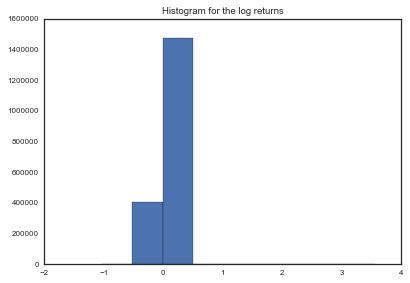

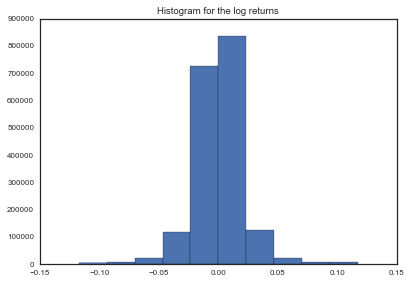

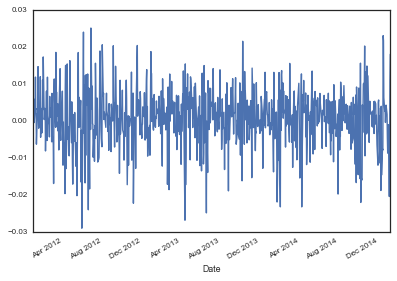

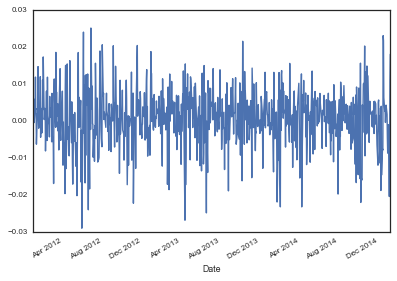

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
path='/Users/cdonnat/Dropbox/Financial Networks/data/'
sys.path.append(path)
import quandl
from utils_preprocessing import *
from correlation import *
from market_alphas import *
from regression import *
from extract_sectors import *
plotpath='/Users/cdonnat/Dropbox/financial-networks/plots/'

stock_data=pickle.load(open(path+'stock_data.pkl','rb'))
Volume_data=pickle.load(open(path+'volume_data.pkl','rb'))
new_stock_data,nb_missing_values,day_missing_values=treat_missing_data(stock_data,verbose=False)
data_log=transform_stock(new_stock_data)
verbose=True
if verbose==True:
    sns.set_context('paper')
    sns.set_style('white')
    plt.figure()
    plt.hist(data_log.as_matrix().reshape([-1,1]))
    plt.title('Histogram for the log returns')
    plt.show()
##
### Cap some outliers
thres=5*(data_log.as_matrix().reshape([-1,1])).std()
data_log=data_log.applymap(lambda x: cap(x,thres))
if verbose==True:
        plt.figure()
        plt.hist(data_log.as_matrix().reshape([-1,1]))
        plt.title('Histogram for the log returns')
        plt.show()
        plt.savefig(plotpath+'hist_log_returns.pdf')



### threshold
stock_returns=data_log.copy()

r_m=compute_market_alpha(stock_data,stock_returns,Volume_data,plot=True)
plt.figure()
r_m.plot()
plt.savefig(plotpath+'market_return.pdf')

In [ ]:
from datetime import datetime
import matplotlib.dates as mdates
colors=['indianred','lightblue','coral','maroon','gold','orange','royalblue','mediumseagreen','violet','grey']
bunch=np.random.choice(data_log.columns,10)

coeff,intercept,MSE,R2=regress_stock_against_market(data_log,r_m,K=5)

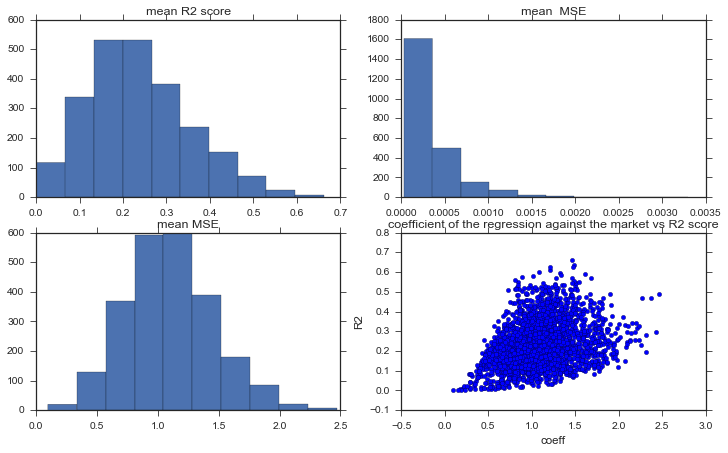

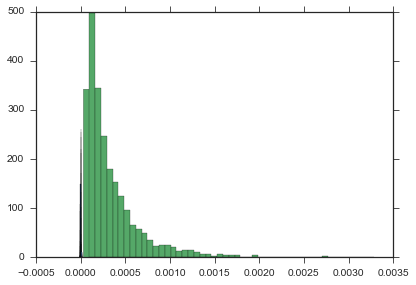

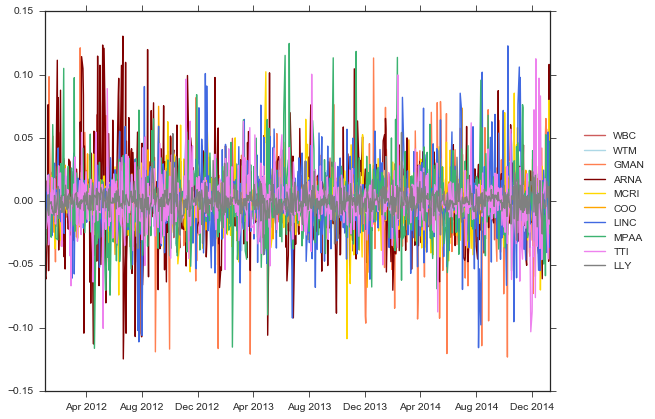

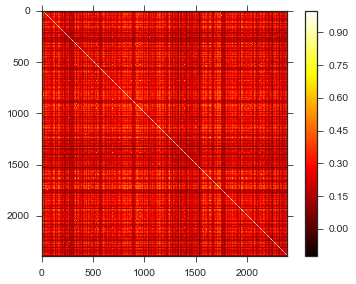

In [11]:
## Check stuff out
fig,((ax1, ax2), (ax3, ax4))=plt.subplots(2,2)
fig.set_figheight(7)
fig.set_figwidth(12)
ax1.hist(R2.mean(0))
ax1.set_title('mean R2 score')
ax2.hist(MSE.mean(0))
ax2.set_title('mean  MSE')
ax3.hist(coeff.mean(0))
ax3.set_title('mean MSE')
ax4.scatter(coeff.mean(0),R2.mean(0))
ax4.set_xlabel('coeff')
ax4.set_ylabel('R2')
ax4.set_title('coefficient of the regression against the market vs R2 score')
plt.savefig(plotpath+'coeff_reg.pdf')
plt.show()


betas=pd.DataFrame(coeff.mean(0)).T
betas=pd.concat([betas]*data_log.shape[0], ignore_index=True)
betas.index=r_m.index
alphas=pd.DataFrame(intercept.mean(0)).T
alphas=pd.concat([alphas]*data_log.shape[0], ignore_index=True)
alphas.index=r_m.index
r_m_df=pd.concat([r_m]*data_log.shape[1], axis=1)
r_m_df.columns=betas.columns
market_effect=betas*r_m_df+alphas
stock_residuals=stock_returns-market_effect


### Compute a few statistics on the residualized returns:
plt.figure()
plt.hist(stock_residuals.mean(0),bins=50)
plt.hist(stock_residuals.var(0),bins=50)

fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='ticks')
sns.set_context("paper", font_scale=1.3)
it_b=0
for b in bunch:
    plt.plot_date(x=data_log.index, y=stock_residuals[b],c=colors[it_b],label=b,fmt='-')
    it_b+=1
#plt.plot_date(x=data_log.index, y=r_m[b],c=colors[it_b],label=b,fmt='-')
plt.legend(loc='center left',bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.savefig(plotpath+'residuals.pdf')
plt.show()

cor_returns=stock_returns.corr()
cor_res=stock_residuals.corr()

plt.figure()
plt.imshow(cor_returns,cmap='hot')
plt.colorbar()

<h2> <span style="color:maroon"> III. The road so far</span> </h2>

In [12]:
import scipy as sc
stock_res={}
corr_pearson={}
corr_spearman={}
years=np.arange(1995,2016)
for y in years:
    print(y)
    stock_res[y]=pickle.load(open('/Users/cdonnat/Dropbox/data/stock_res'+str(y)+'.pkl','rb'))
    if stock_res[y].shape[0]>stock_res[y].shape[1]:
        stock_res[y]=stock_res[y].T
    corr_pearson[y]=stock_res[y].corr()
    corr_spear, pval =sc.stats.spearmanr(stock_res[y])
    corr_spearman[y]=pd.DataFrame(corr_spear, index=stock_res[y].columns, columns=stock_res[y].columns)

1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


In [13]:
start=1995
end=2016
nodes_total=[]
for y in np.arange(start, end):
        nodes_total+=[c for c in corr_pearson[y].index]
nodes_total=list(set(nodes_total))

for y in np.arange(start, end):
        diff=np.setdiff1d(nodes_total,[c for c in corr_pearson[y].index])
        corr_pearson[y]=pd.concat([corr_pearson[y],\
                              pd.DataFrame(np.zeros((corr_pearson[y].shape[0],len(diff))),\
                              index=corr_pearson[y].index,columns=diff)],1)
        corr_pearson[y]=pd.concat([corr_pearson[y],\
                              pd.DataFrame(np.zeros((len(diff),corr_pearson[y].shape[1])),\
                              columns=corr_pearson[y].columns,index=diff) ]) 
        corr_spearman[y]=pd.concat([corr_spearman[y],\
                              pd.DataFrame(np.zeros((corr_spearman[y].shape[0],len(diff))),\
                              index=corr_spearman[y].index,columns=diff)],1)
        corr_spearman[y]=pd.concat([corr_spearman[y],\
                              pd.DataFrame(np.zeros((len(diff),corr_spearman[y].shape[1])),\
                              columns=corr_spearman[y].columns,index=diff) ]) 
        


In [15]:
Stop_year=2016
years=range(1995,Stop_year,1)  

cor_res={}
Boot={}
B=200
edges={}
nodes={}
G={}
A={}
import networkx as nx
Stop_year=2016
for y in range(1995,Stop_year):
    #cor_res[y]=pickle.load(open('/Users/cdonnat/Dropbox/data/cor_res'+str(y)+'.pkl','rb'))
    #pickle.dump(dict_cor,open('/Users/cdonnat/Dropbox/data/dict_cor_1day'+str(y)+'.pkl','wb'))
    edges[y]=pd.DataFrame.from_csv('/Users/cdonnat/Dropbox/data/edges_B2_'+str(y)+'.csv')
    nodes[y]=pd.DataFrame.from_csv('/Users/cdonnat/Dropbox/data/nodes_B2_'+str(y)+'.csv')
    
    print(y)
    edges[y]['weight']=pd.to_numeric(edges[y]['weight'])
    print(edges[y].iloc[:5,2])
    G[y]=nx.from_pandas_dataframe(edges[y],source='Source',target='Target',edge_attr='weight')
    print(G[y]['AGN'])
    A[y]=nx.adjacency_matrix(G[y]).todense()
    A[y]=pd.DataFrame(A[y],index=G[y].nodes(),columns=G[y].nodes())

1995
0    0.230769
1   -0.025641
2    1.000000
3    1.000000
4   -0.076923
Name: weight, dtype: float64
{'lev_0.23_0': {'weight': 0.986532667648}, 'PICO': {'weight': 0.23076923076900002}, 'AIRM': {'weight': 0.23076923076900002}}
1996
0    0.977212
1   -0.003172
2   -0.025323
3   -0.025641
4   -0.025641
Name: weight, dtype: float64
{'JBHT': {'weight': 0.23076923076900002}, 'LSTR': {'weight': 0.23076923076900002}, 'TQNT': {'weight': 0.23076923076900002}, 'WLT': {'weight': 0.23076923076900002}, 'ERIE': {'weight': 0.23076923076900002}, 'CPT': {'weight': 0.23076923076900002}, 'QLGC': {'weight': 0.23076923076900002}, 'SCLN': {'weight': 0.23076923076900002}, 'BWA': {'weight': 0.23076923076900002}, 'SPF': {'weight': 0.23076923076900002}, 'SPG': {'weight': 0.23076923076900002}, 'WRB': {'weight': 0.23076923076900002}, 'WRI': {'weight': 0.23076923076900002}, 'lev_0.33_49': {'weight': 0.23076923076900002}, 'lev_0.33_46': {'weight': 0.23076923076900002}, 'VTSS': {'weight': 0.23076923076900002}, 'NP

In [16]:
import seaborn as sb
distance_corr_spearman=pd.DataFrame(np.zeros((len(A.keys()),len(A.keys()))),index=A.keys(),columns=A.keys())
distance_corr_pearson=pd.DataFrame(np.zeros((len(A.keys()),len(A.keys()))),index=A.keys(),columns=A.keys())
for i in range(1, len(A.keys())):
    ki=A.keys()[i]
    print(ki)
    for j in range(0,i):
        kj=A.keys()[j]
        distance_corr_pearson.loc[ki,kj]=np.linalg.norm(corr_pearson[kj]-corr_pearson[ki])/np.linalg.norm(corr_pearson[kj]+corr_pearson[ki])
        distance_corr_spearman.loc[ki,kj]=np.linalg.norm(corr_spearman[kj]-corr_spearman[ki])/np.linalg.norm(corr_spearman[kj]+corr_spearman[ki])

distance_corr_spearman=distance_corr_spearman+distance_corr_spearman.T
distance_corr_pearson=distance_corr_pearson+distance_corr_pearson.T

1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


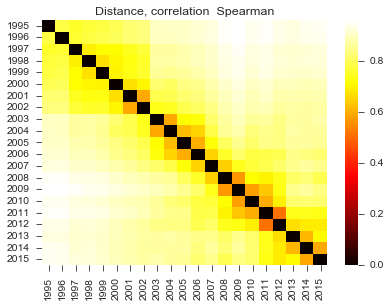

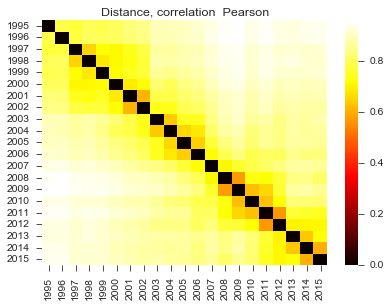

In [17]:

plt.figure()
sb.heatmap(distance_corr_spearman,cmap='hot')
plt.title('Distance, correlation  Spearman')
plt.savefig(plotpath+'Spearman_corr.pdf')
plt.figure()
sb.heatmap(distance_corr_pearson,cmap='hot')
plt.title('Distance, correlation  Pearson')
plt.savefig(plotpath+'Pearson_corr.pdf')

In [14]:
clusters_pears_labels={}
clusters_spear_labels={}
for n in range(2,100):
    clusters_pears_labels[n]=pd.DataFrame.from_csv('/Users/cdonnat/Dropbox/data/clusters_pearson_'+str(n)+'.csv')
    clusters_spear_labels[n]=pd.DataFrame.from_csv('/Users/cdonnat/Dropbox/data/clusters_spearman_'+str(n)+'.csv')

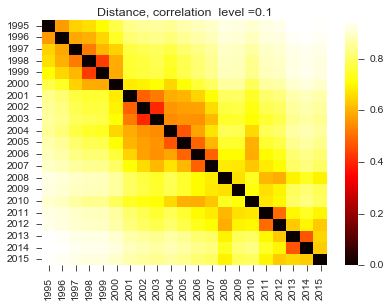

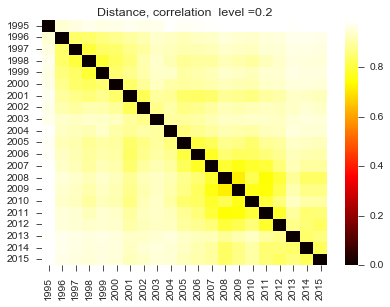

In [20]:
import seaborn as sb
dist=pd.DataFrame.from_csv('/Users/cdonnat/Dropbox/data/dist_'+str(0.1)+'.csv')
dist.index=dist.columns
plt.figure()
sb.heatmap(dist,cmap='hot')
plt.title('Distance, correlation  level =0.1')
plt.savefig(plotpath+'corr01.pdf')

dist02=pd.DataFrame.from_csv('/Users/cdonnat/Dropbox/data/dist_'+str(0.2)+'.csv')
dist02.index=dist02.columns
plt.figure()
sb.heatmap(dist02,cmap='hot')
plt.title('Distance, correlation  level =0.2')
plt.savefig(plotpath+'corr02.pdf')

We might have to use different metrics for different correlations levels...

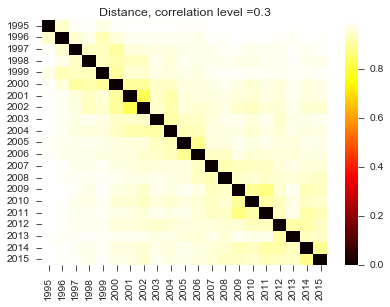

In [21]:
dist03=pickle.load(open('/Users/cdonnat/Dropbox/data/dist_0.3.pkl','rb'))
dist03.index=dist03.columns
plt.figure()
sb.heatmap(dist03,cmap='hot')
plt.title('Distance, correlation level =0.3')
plt.savefig(plotpath+'corr03.pdf')

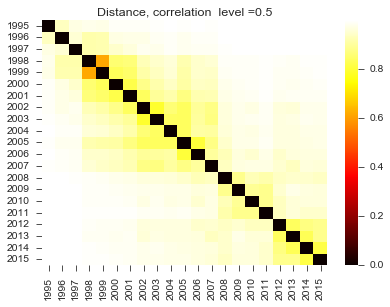

In [22]:
dist05=pickle.load(open('/Users/cdonnat/Dropbox/data/dist_0.5.pkl','rb'))
dist05.index=dist05.columns
plt.figure()
sb.heatmap(dist05,cmap='hot')
plt.title('Distance, correlation  level =0.5')
plt.savefig(plotpath+'corr05.pdf')

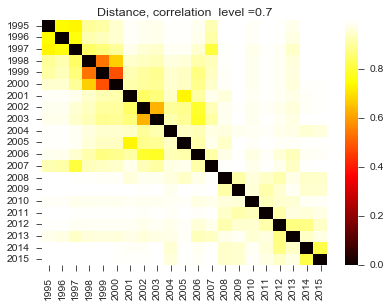

In [23]:
dist07=pickle.load(open('/Users/cdonnat/Dropbox/data/dist_0.7.pkl','rb'))
dist07.index=dist07.columns
plt.figure()
sb.heatmap(dist07,cmap='hot')
plt.title('Distance, correlation  level =0.7')
plt.savefig(plotpath+'corr07.pdf')

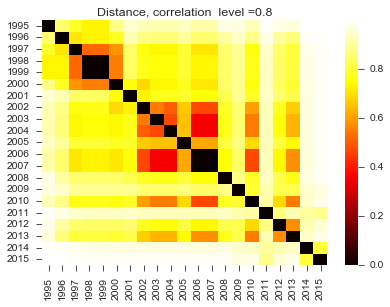

In [26]:
dist08=pickle.load(open('/Users/cdonnat/Dropbox/data/dist_0.8.pkl','rb'))
dist08.index=dist08.columns
plt.figure()
sb.heatmap(dist08,cmap='hot')
plt.title('Distance, correlation  level =0.8')
plt.savefig(plotpath+'corr08.pdf')

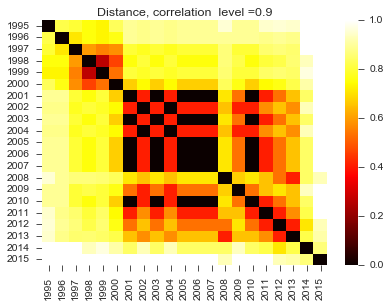

In [27]:
dist09=pickle.load(open('/Users/cdonnat/Dropbox/data/dist_0.9.pkl','rb'))
dist09.index=dist09.columns
plt.figure()
sb.heatmap(dist09,cmap='hot')
plt.title('Distance, correlation  level =0.9')
plt.savefig(plotpath+'corr09.pdf')

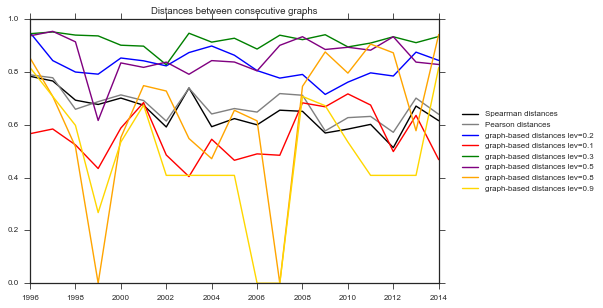

In [33]:
Stop_year=2015
years=range(1995,Stop_year)
plt.figure()
sns.set_context('paper')
plt.plot(years[1:],[distance_corr_spearman.loc[y,y+1] for y in range(1995,Stop_year-1)],c='black',label='Spearman distances' )
plt.plot(years[1:],[distance_corr_pearson.loc[y,y+1] for y in range(1995,Stop_year-1)],c='grey',label='Pearson distances' )

plt.plot(years[1:],[dist02.loc[str(y),str(y+1)] for y in range(1995,Stop_year-1)],c='blue',label='graph-based distances lev=0.2' )
plt.plot(years[1:],[dist.loc[str(y),str(y+1)] for y in range(1995,Stop_year-1)],c='red',label='graph-based distances lev=0.1' )
plt.plot(years[1:],[dist03.loc[y,y+1] for y in range(1995,Stop_year-1)],c='green',label='graph-based distances lev=0.3' )
plt.plot(years[1:],[dist05.loc[y,y+1] for y in range(1995,Stop_year-1)],c='purple',label='graph-based distances lev=0.5' )
plt.plot(years[1:],[dist08.loc[y,y+1] for y in range(1995,Stop_year-1)],c='orange',label='graph-based distances lev=0.8' )
plt.plot(years[1:],[dist09.loc[y,y+1] for y in range(1995,Stop_year-1)],c='gold',label='graph-based distances lev=0.9' )
#plt.plot(years[1:],[distance_corr_pearson.loc[i,i+1] for i in range(1995,Stop_year-1)],c='green',label='Pearson correlation distances' )
plt.title('Distances between consecutive graphs')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.savefig(plotpath+'distance_consecutive_graphs.pdf', bbox_inches='tight')

/Users/cdonnat/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


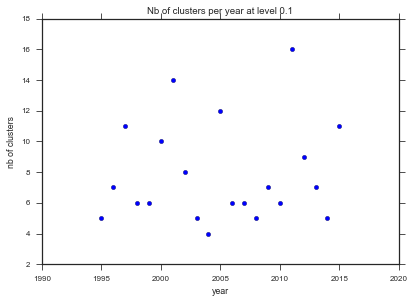

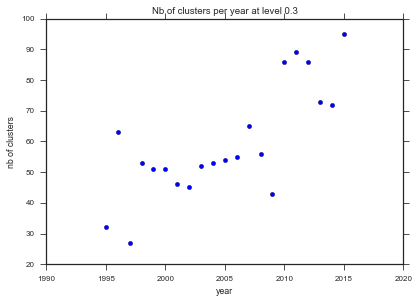

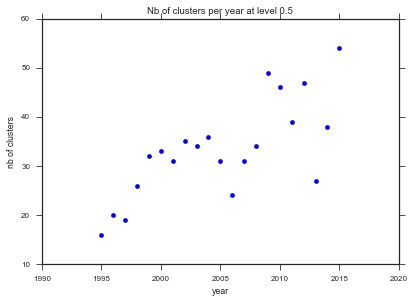

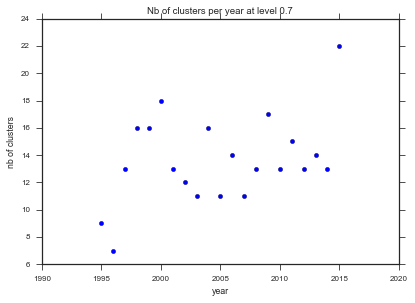

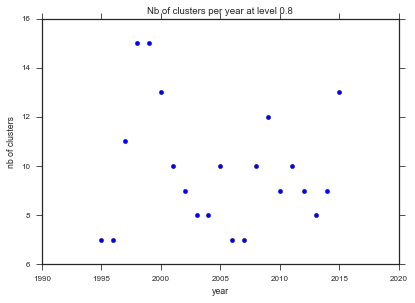

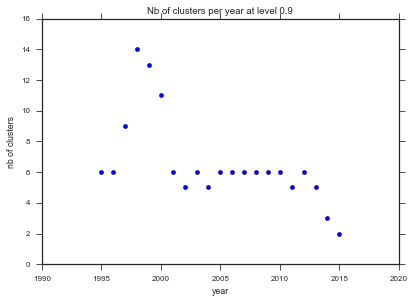

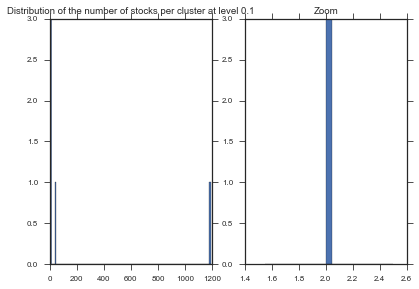

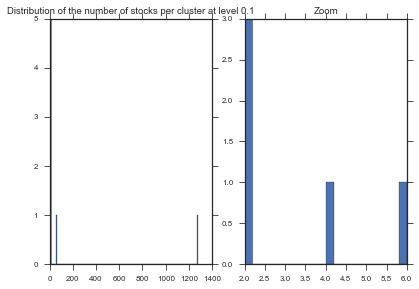

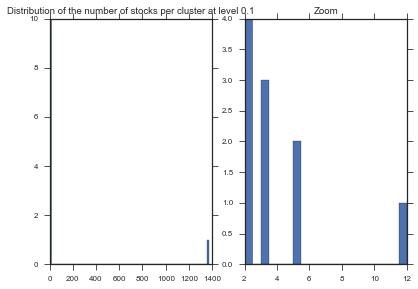

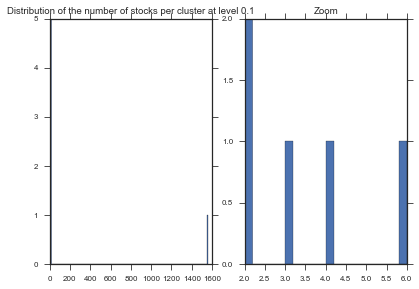

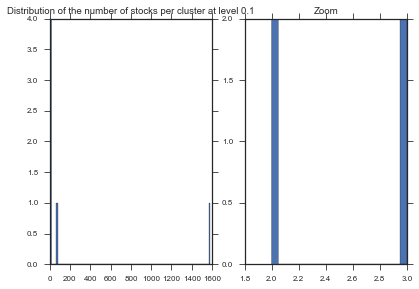

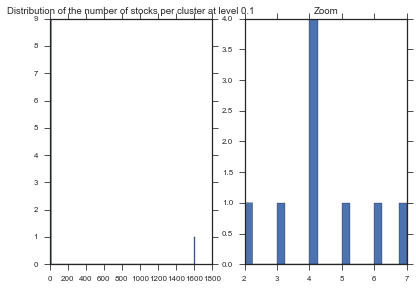

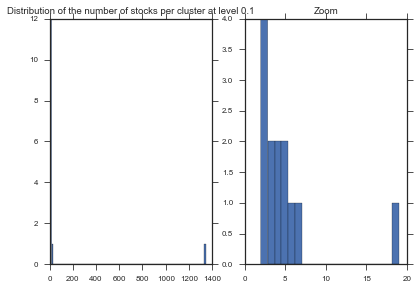

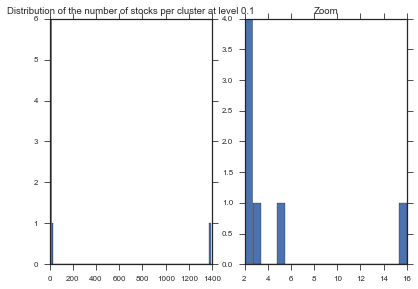

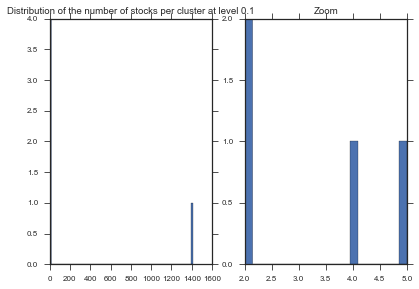

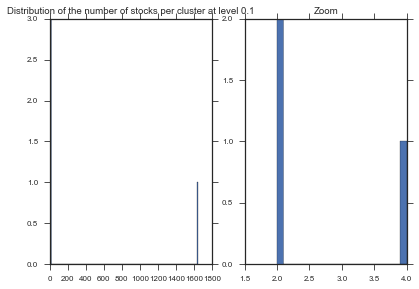

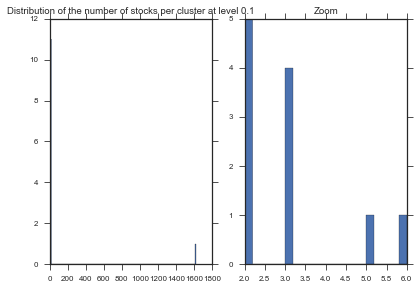

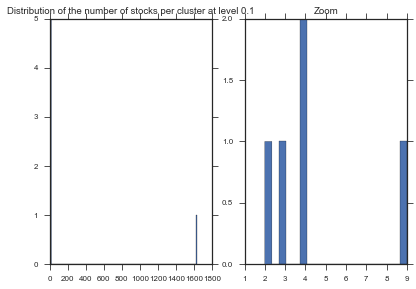

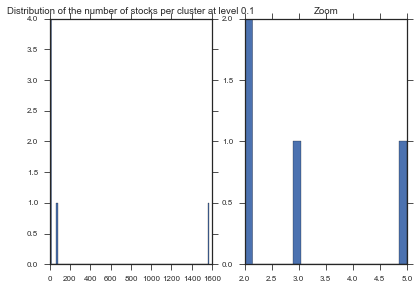

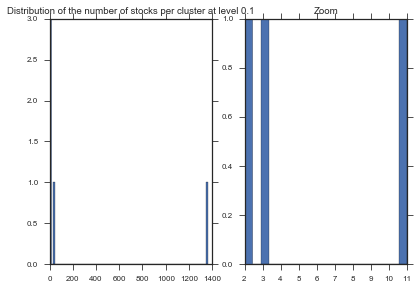

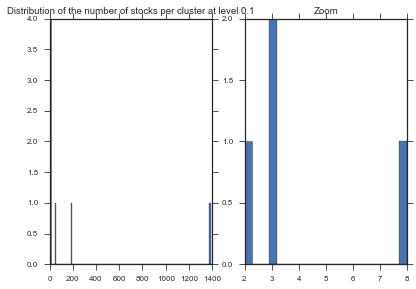

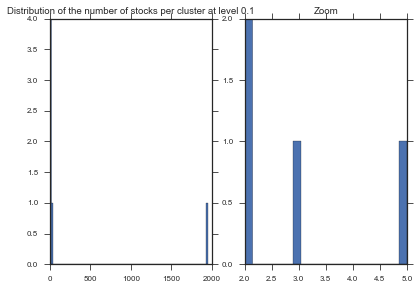

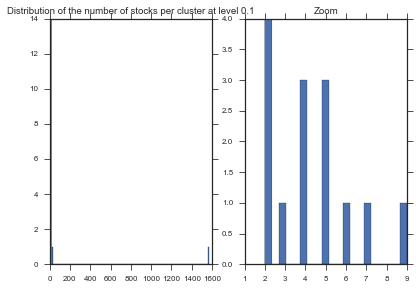

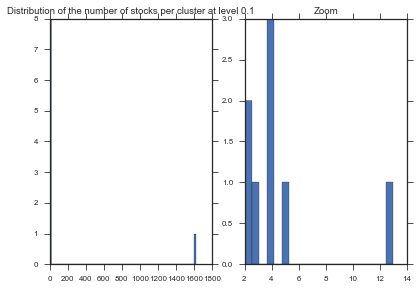

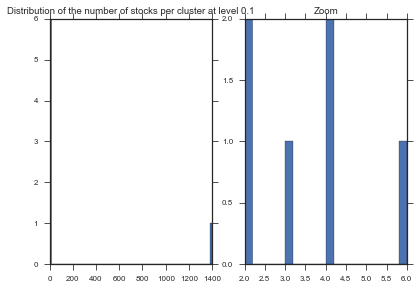

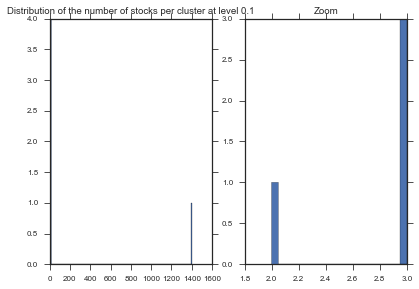

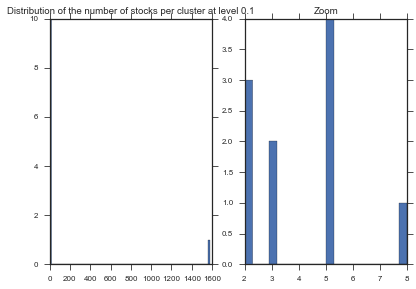

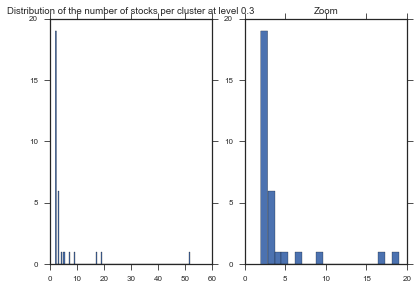

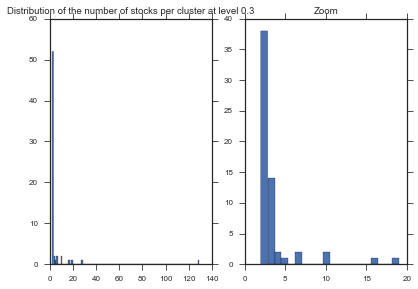

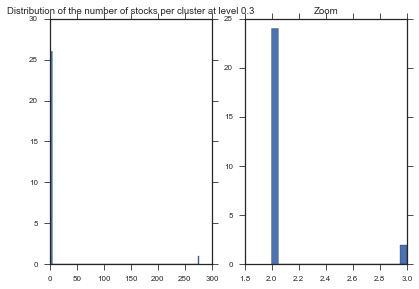

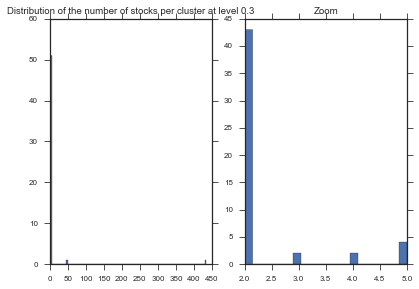

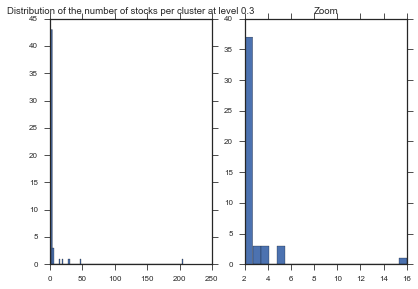

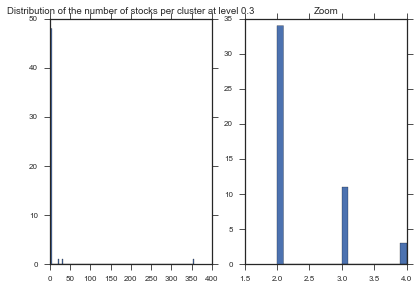

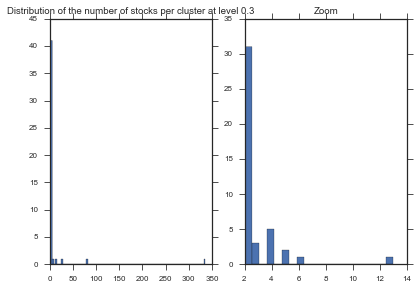

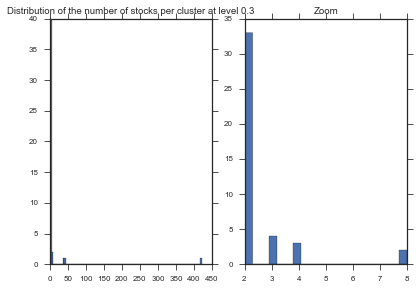

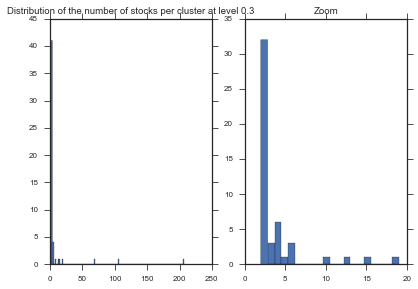

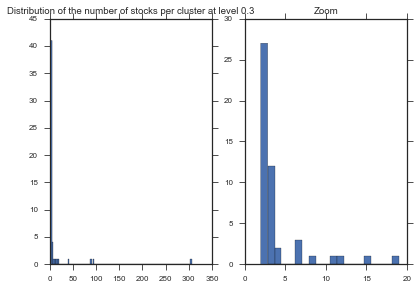

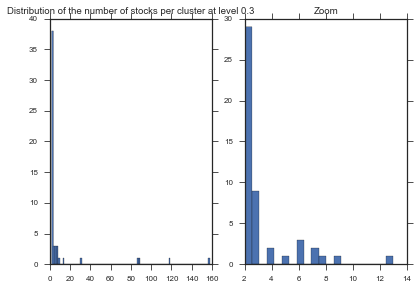

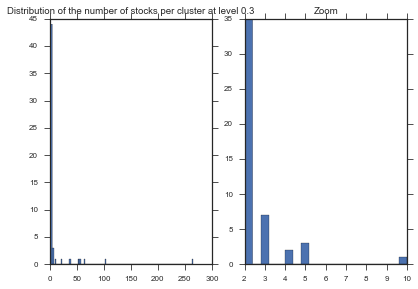

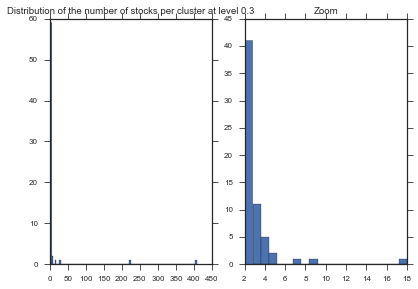

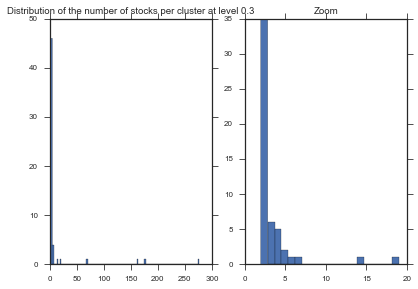

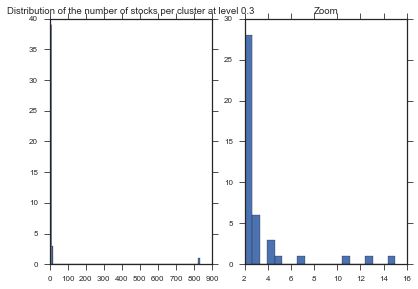

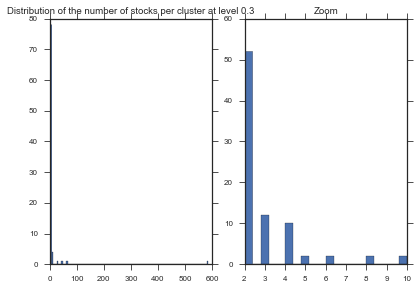

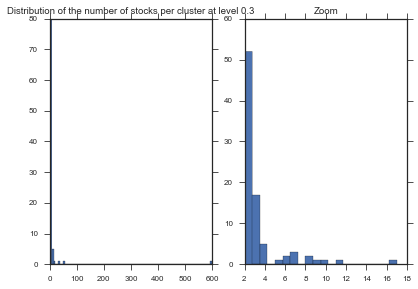

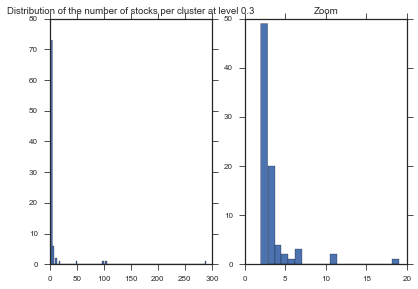

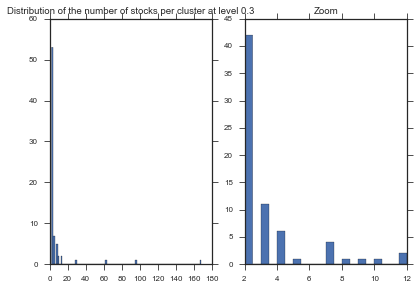

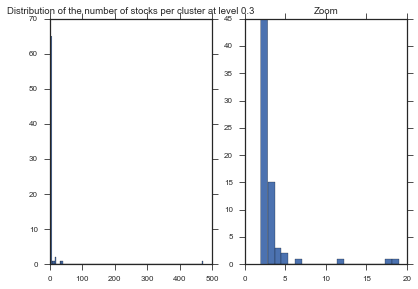

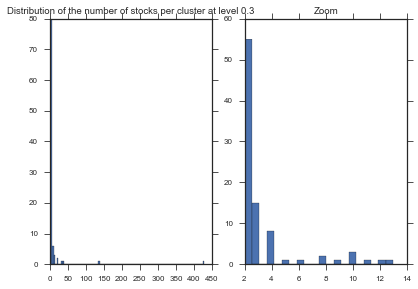

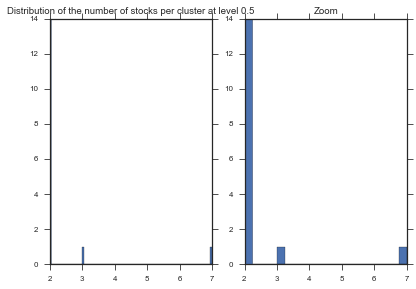

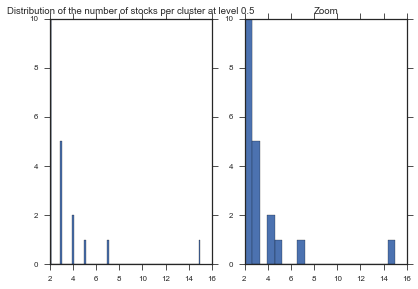

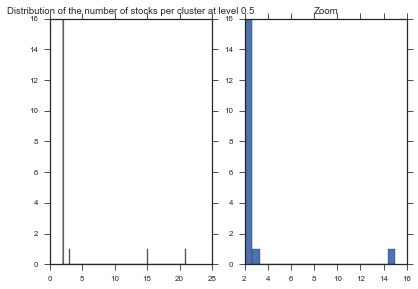

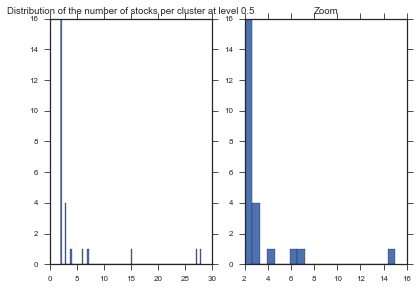

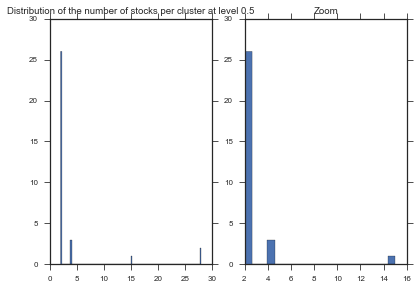

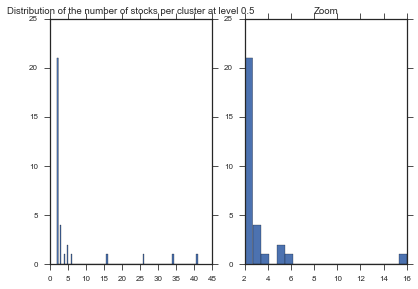

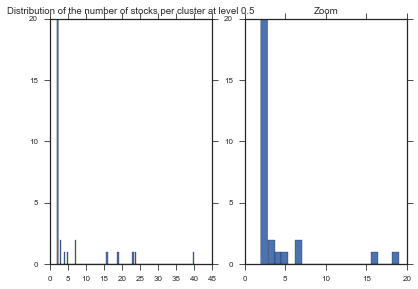

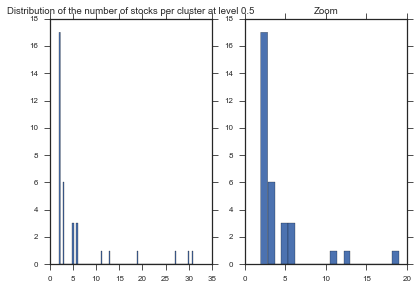

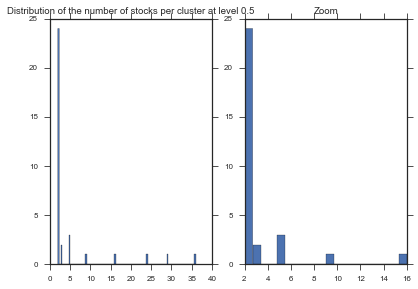

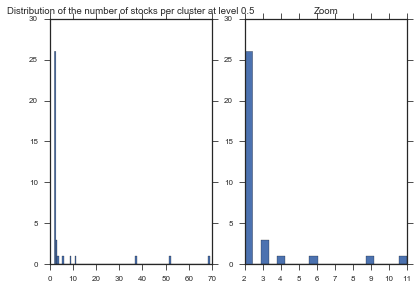

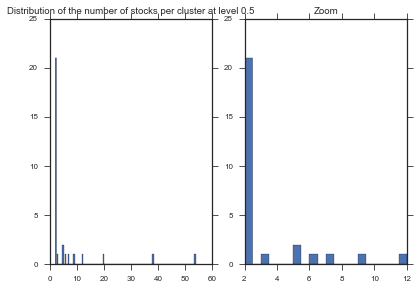

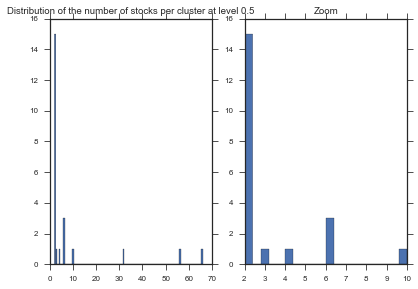

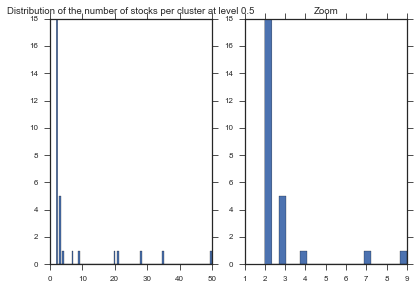

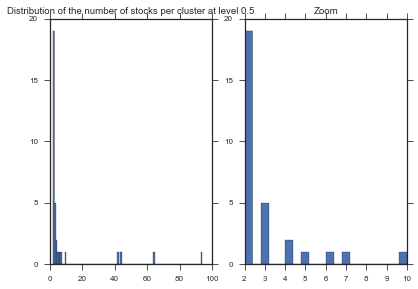

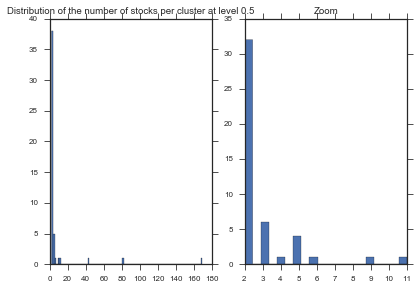

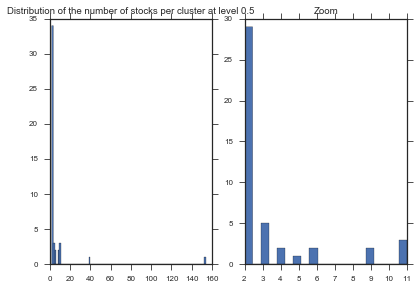

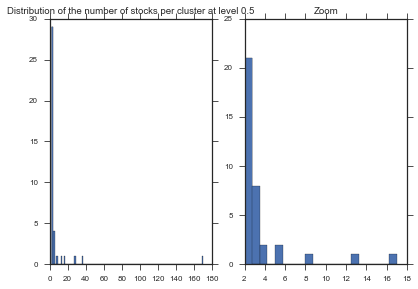

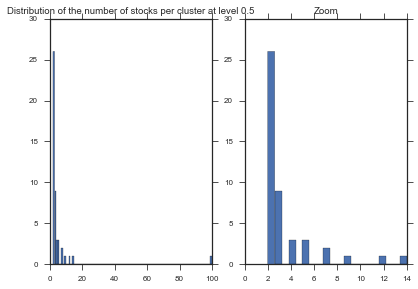

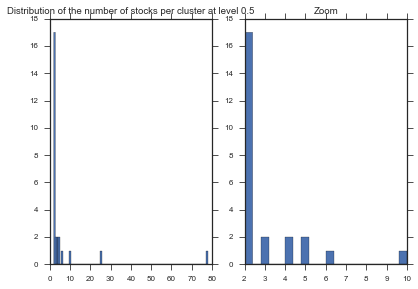

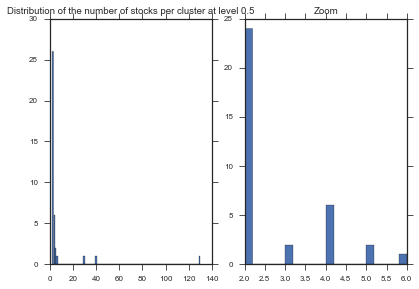

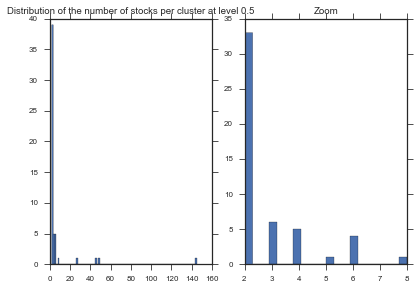

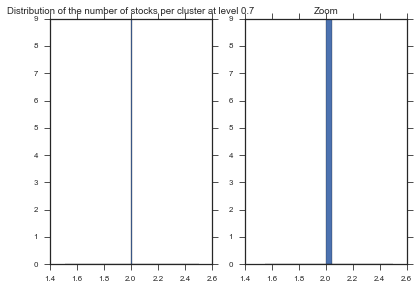

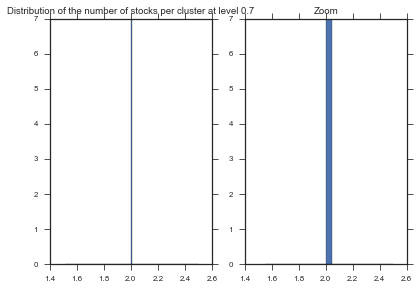

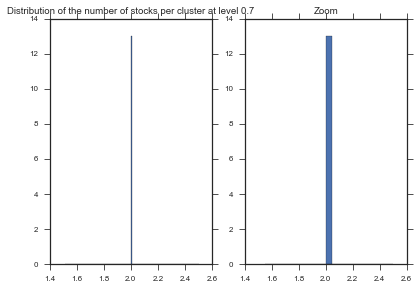

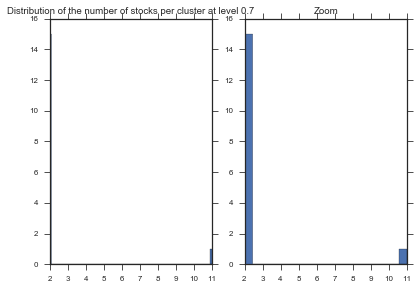

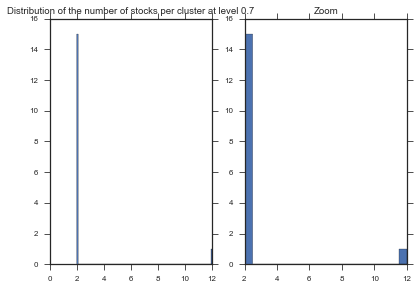

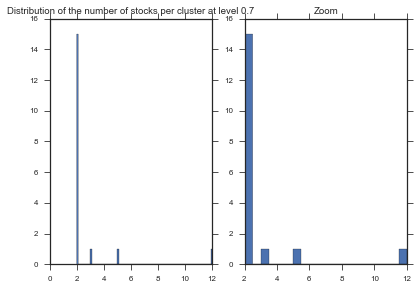

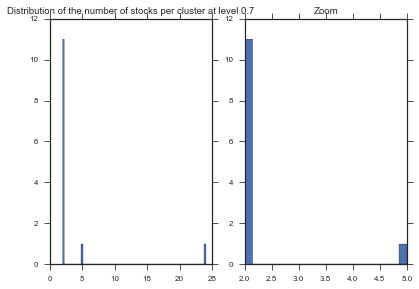

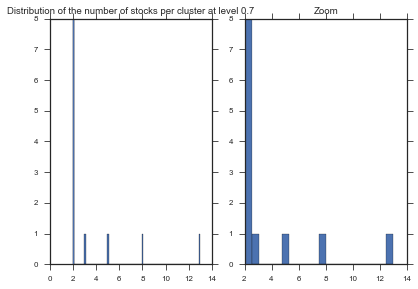

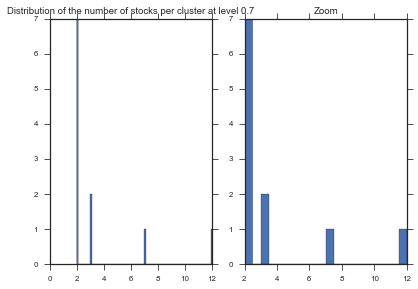

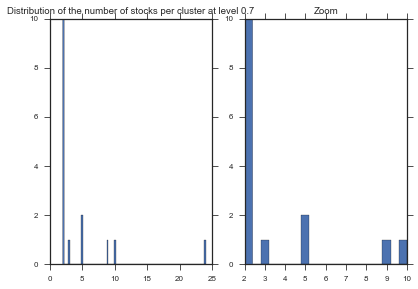

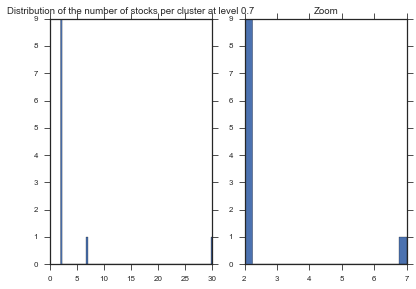

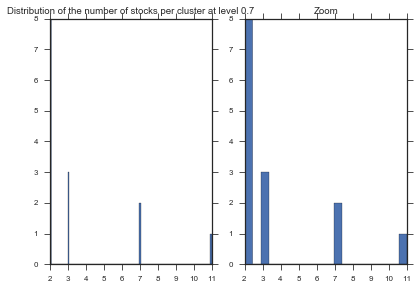

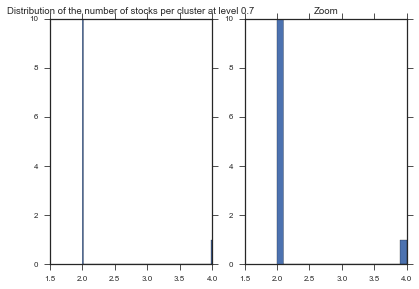

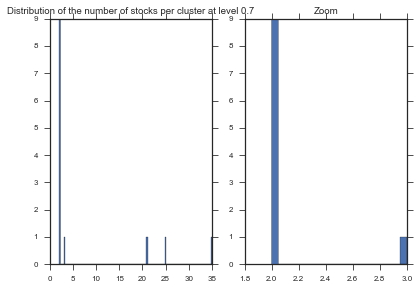

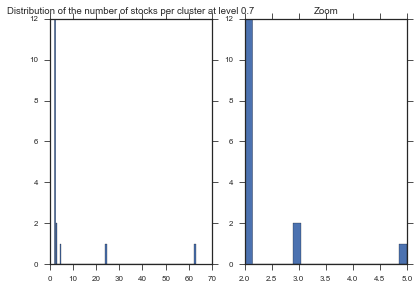

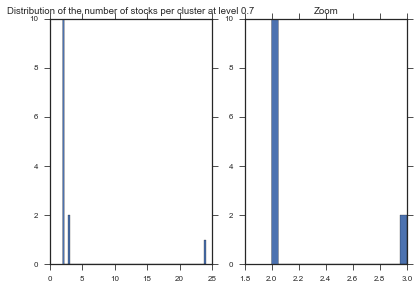

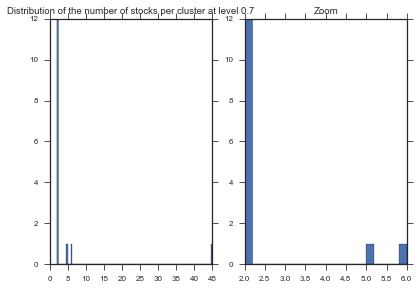

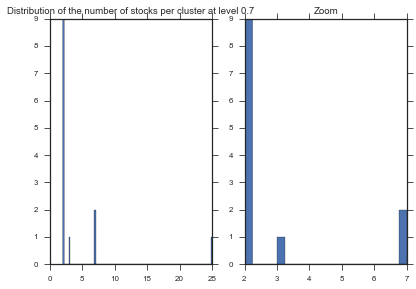

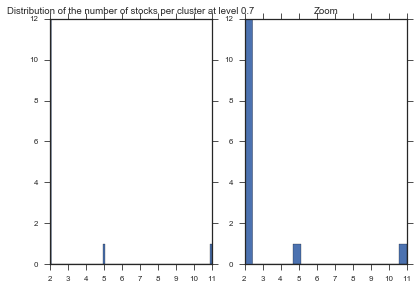

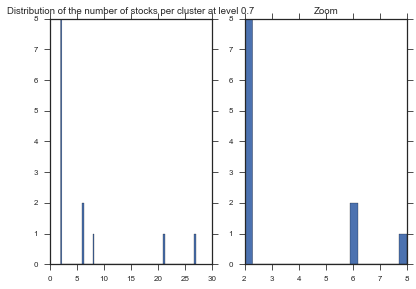

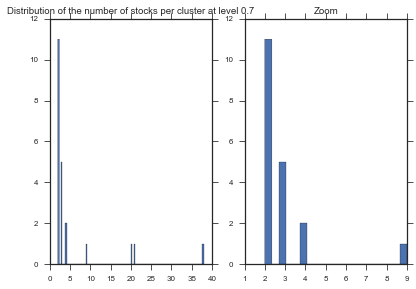

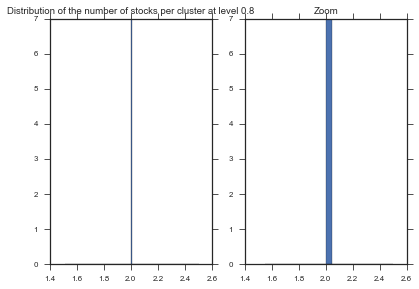

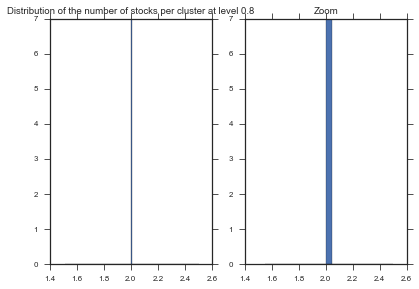

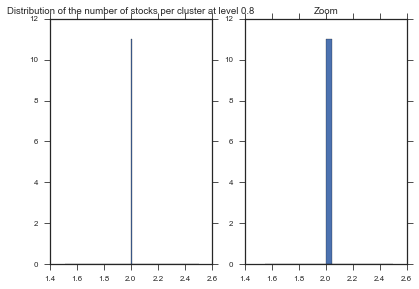

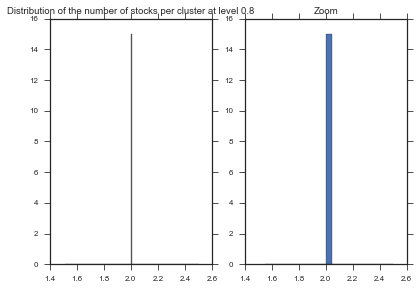

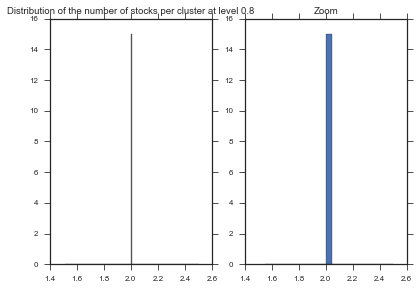

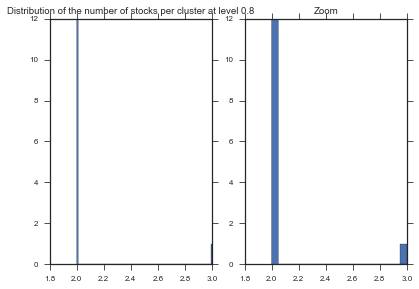

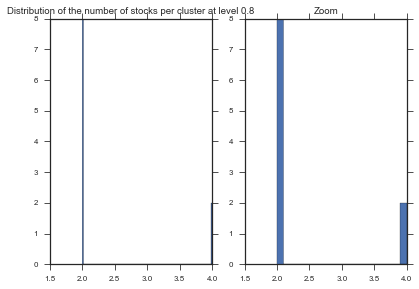

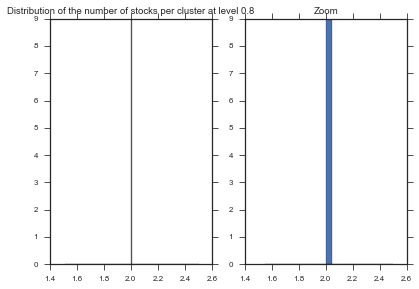

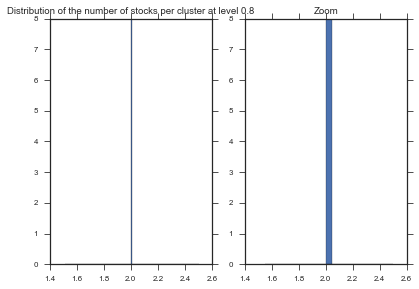

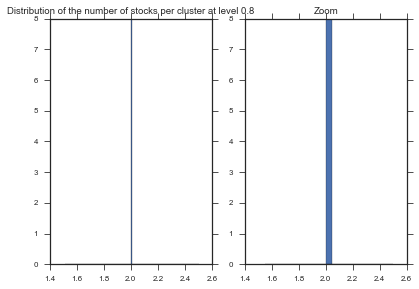

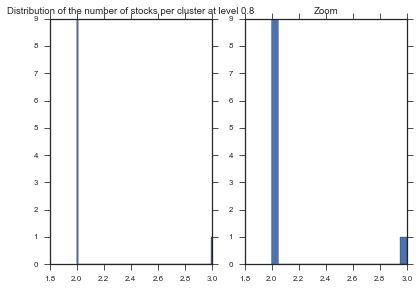

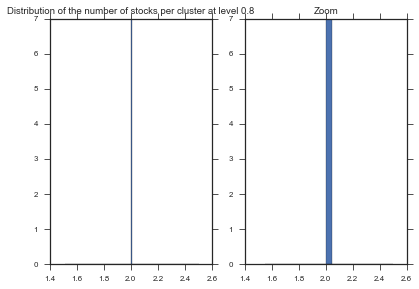

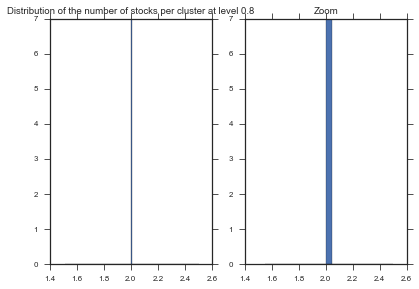

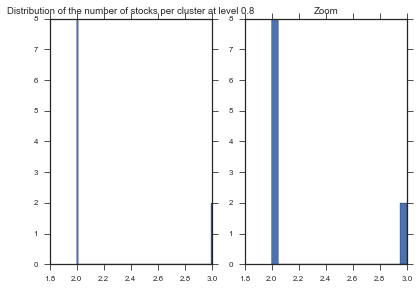

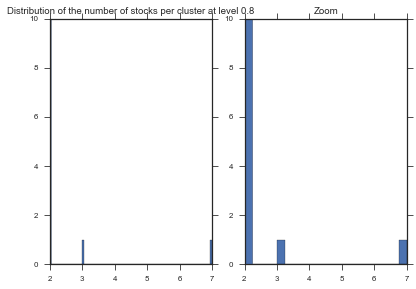

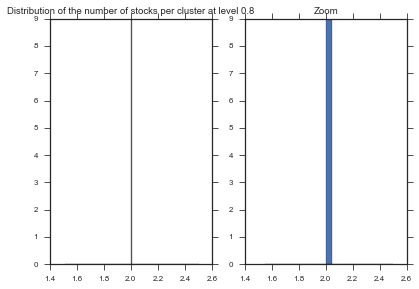

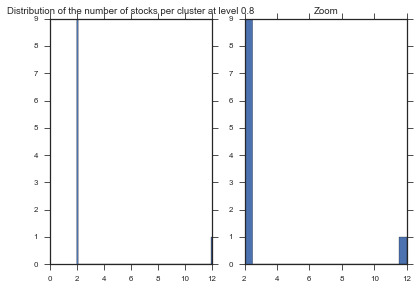

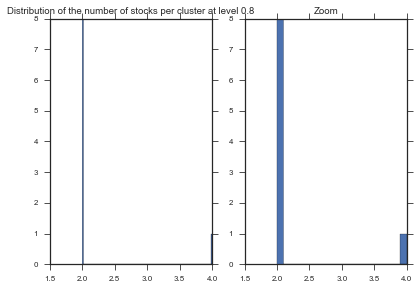

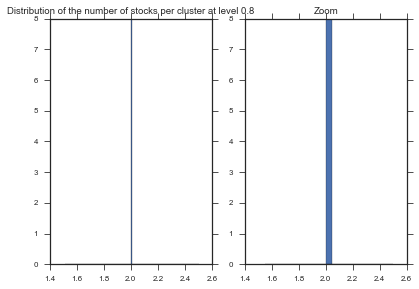

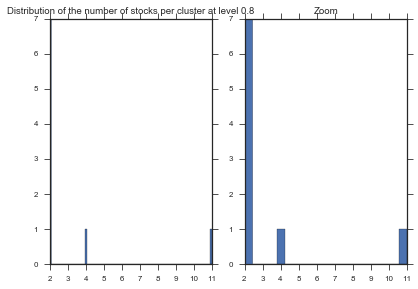

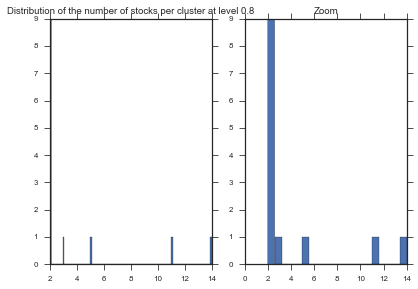

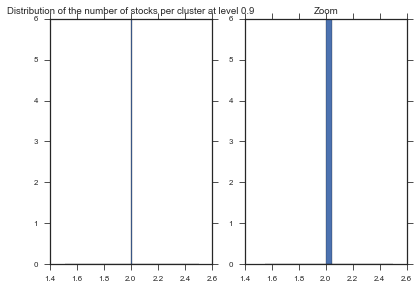

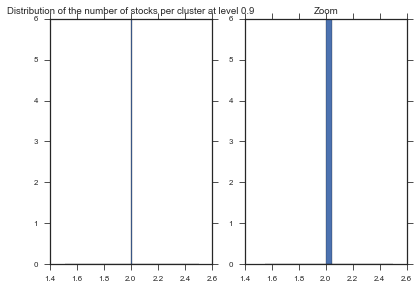

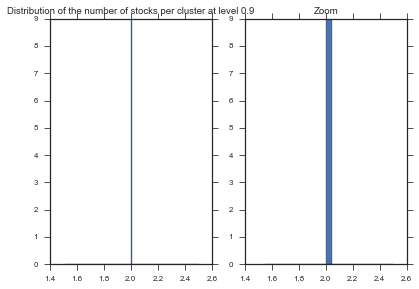

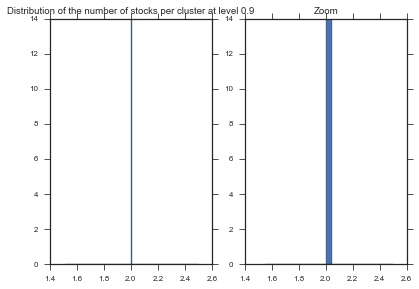

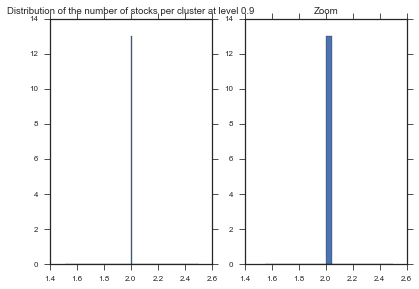

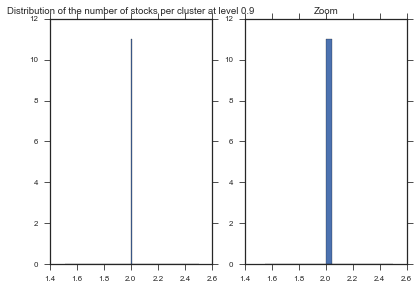

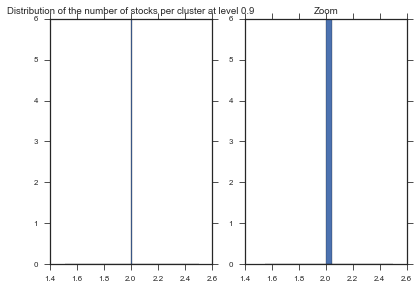

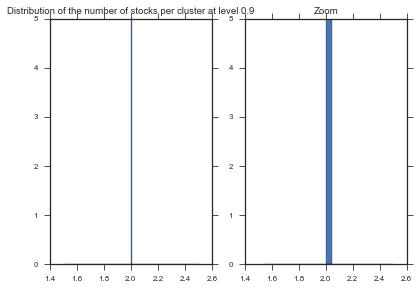

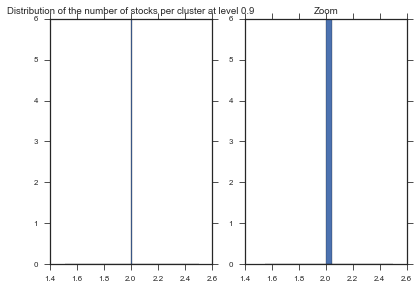

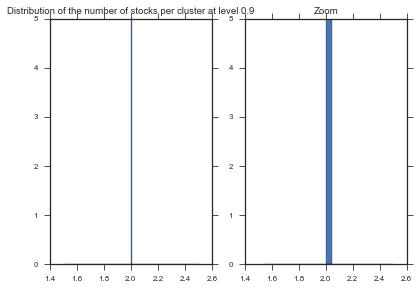

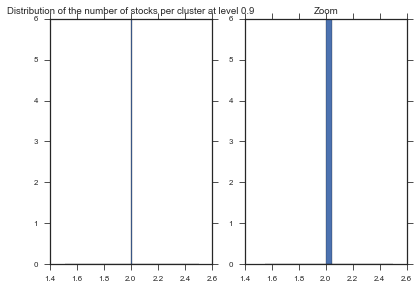

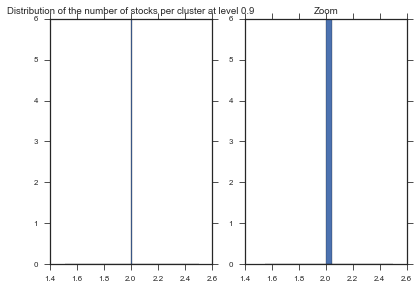

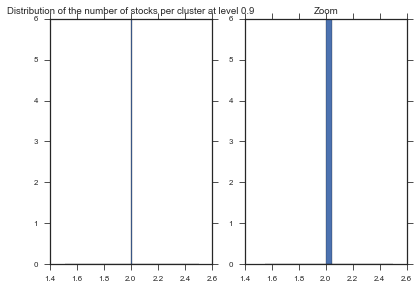

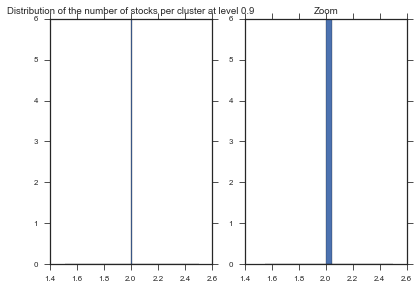

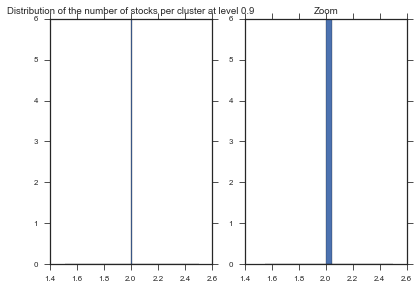

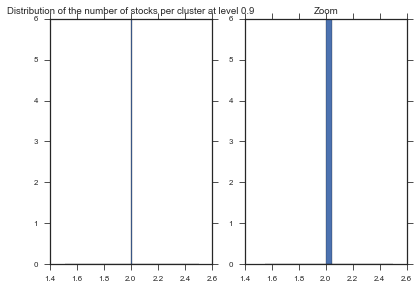

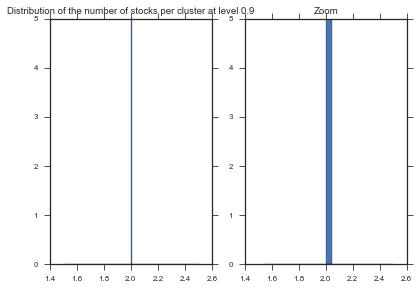

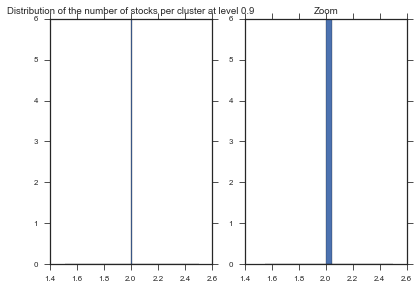

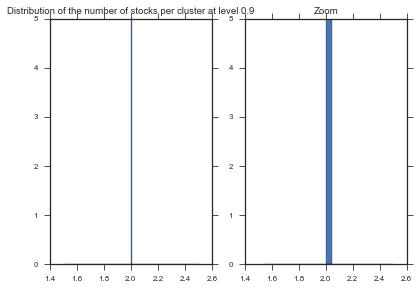

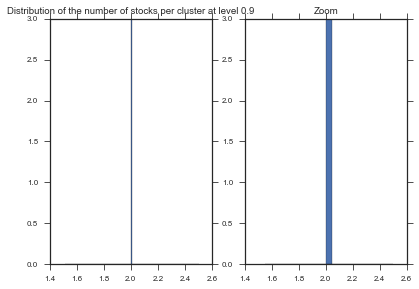

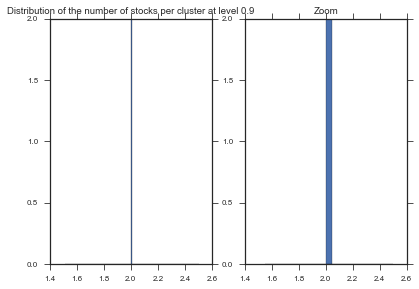

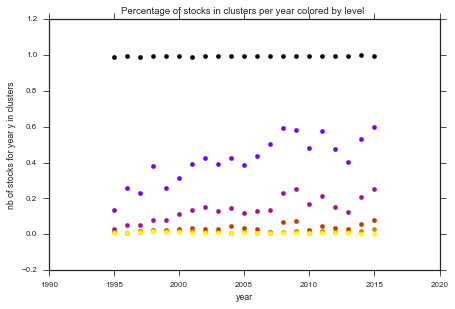

In [35]:
C={}
levels=[0.1,0.3,0.5,0.7,0.8,0.9]
for lev in levels:
    C[lev]=pickle.load(open('/Users/cdonnat/Dropbox/data/C2_'+str(lev)+'.pkl'))
    
for lev in levels:
    plt.figure()
    for k in C[lev].keys():
        plt.scatter(k,len(C[lev][k]))
    plt.xlabel('year')
    plt.ylabel('nb of clusters')
    plt.title('Nb of clusters per year at level '+str(lev))
for lev in levels:
    for y in range(1995,2016):
        fig,(ax1,ax2)=plt.subplots(1,2)
        ax1.hist([len(C[lev][y][c]) for c in C[lev][y].keys()],bins=100)
        ax1.set_title('Distribution of the number of stocks per cluster at level '+str(lev))
        ax2.hist([len(C[lev][y][c]) for c in C[lev][y].keys() if len(C[lev][y][c]) <20],bins=20)
        ax2.set_title('Zoom')

plt.savefig(plotpath+'ditr_stock_size.pdf', bbox_inches='tight')        
        
plt.figure()
cmap=plt.get_cmap('gnuplot')
color=cmap(np.linspace(0,1,6))
colors={levels[i]:color[i] for i in range(6)}
for lev in levels:
    for k in C[lev].keys():
        Boot[k]=pickle.load(open('/Users/cdonnat/Dropbox/data/Boot'+str(k)+'.pkl','rb'))
        plt.scatter(k,np.sum([len(C[lev][k][c]) for c in C[lev][k].keys()])*1.0/len(Boot[k].index),color=colors[lev])
plt.xlabel('year')
plt.ylabel('nb of stocks for year y in clusters')
plt.title('Percentage of stocks in clusters per year colored by level ')
plt.tight_layout()
plt.savefig(plotpath+'percentage_stock_in_clusters.pdf', bbox_inches='tight')

### Evaluate the risk of a Portfolio


In [38]:
## select random stocks
from extract_sectors import *
path_sectors='/Users/cdonnat/Dropbox/Financial Networks/data/'
CompanyInfo=load_sectors2(path_sectors,filename='book_CompanyInfo.csv')
stocks=CompanyInfo[['Sector','Industry','Industry_subgroup','Sector_key','Industry_key','Industry_subgroup_key']]
for n in range(2,100):
    print(n)
    for y in range(1995,2016):
        stocks.loc[clusters_pears_labels[n][str(y)].index,'pearson_'+str(n)+'_'+str(y)]=clusters_pears_labels[n][str(y)]
        stocks.loc[clusters_spear_labels[n][str(y)].index,'spearman_'+str(n)+'_'+str(y)]=clusters_spear_labels[n][str(y)]
        

2


NameError: name 'clusters_pears_labels' is not defined

In [32]:
stocks=stocks.loc[clusters_pears_labels[n][str(y)].index]

In [109]:
core_nodes=list(stock_res[1995].columns.values)
for y in range(1996,2016):
    core_nodes=np.intersect1d(core_nodes,stock_res[y].columns.values)

    

In [110]:
len(core_nodes)

553

In [111]:
sample_stock=np.random.choice(core_nodes,200,replace=False)

In [112]:
sample_weights=[np.random.choice(range(200)) for i in  range(200)]
sample_weights=pd.DataFrame(1.0/np.sum(sample_weights)*np.array(sample_weights).reshape([1,200]),columns=sample_stock)


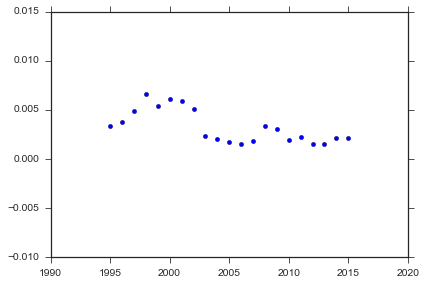

In [113]:
r_portfolio={}
plt.figure()
for y in stock_res.keys():
    r_portfolio[y]=(stock_res[y].loc[:,sample_stock].fillna(0)).dot(sample_weights.T)
    plt.scatter(y,r_portfolio[y].std())
    

In [114]:
## estimated volatility
mean_corr_pearson=corr_pearson[1995]
mean_corr_spear=corr_spearman[1995]
for y in range(1996,2016):
    mean_corr_pearson+=corr_pearson[y]
    mean_corr_spear+=corr_spearman[y]

In [115]:
Diag_spear=np.diag(1.0/np.sqrt(np.diag(mean_corr_spear)))
Diag_pears=np.diag(1.0/np.sqrt(np.diag(mean_corr_pearson)))
mean_corr_pearson2=pd.DataFrame(Diag_pears.dot(mean_corr_pearson.dot(Diag_pears)),index=mean_corr_pearson.index,columns=mean_corr_pearson.columns)
mean_corr_spear2=pd.DataFrame(Diag_spear.dot(mean_corr_spear.dot(Diag_spear)),index=mean_corr_spear.index,columns=mean_corr_spear.columns)

In [214]:
vol_spear=[]
vol_pears=[]
for y in range(1998,2016):
    mean_corr_pearson=1.0/3*corr_pearson[y-3]
    mean_corr_spear=1.0/3*corr_spearman[y-3]
    Vol=1.0/3*stock_res[y-3][sample_stock].var()
    for i in range(1,3):
        mean_corr_pearson+=1.0/3*corr_pearson[y-i]
        mean_corr_spear+=1.0/3*corr_spearman[y-i]
        Vol+=1.0/3*stock_res[y-i][sample_stock].var()
    Vol=pd.DataFrame(np.sqrt(Vol))
    Var_s=mean_corr_spear.loc[sample_stock,sample_stock].apply(lambda x: x*float(Vol.loc[x.name]),1)
    Var_s=(mean_corr_spear.loc[sample_stock,sample_stock].T).apply(lambda x: x*float(Vol.loc[x.name]),1)
    Var_p=mean_corr_pearson.loc[sample_stock,sample_stock].apply(lambda x: x*float(Vol.loc[x.name]),1)
    Var_p=(mean_corr_pearson.loc[sample_stock,sample_stock].T).apply(lambda x: x*float(Vol.loc[x.name]),1)
    vol_spear.append((sample_weights.T).dot(Var_s.dot(sample_weights)))
    vol_pears.append(((sample_weights.T).dot(Var_p.dot(sample_weights))))
vol_spear=pd.DataFrame(vol_spear,index=range(1998,2016))
vol_pears=pd.DataFrame(vol_pears,index=range(1998,2016))

In [178]:
mean_corr_pearson=1.0/3.0*corr_pearson[y-3]
mean_corr_spear=1.0/3.0*corr_spearman[y-3]
Vol=1.0/3*stock_res[y-3][sample_stock].var()
for i in range(1,2):
        mean_corr_pearson+=1.0/3*corr_pearson[y-i].loc[sample_stock][sample_stock]
        mean_corr_spear+=1.0/3*corr_spearman[y-i].loc[sample_stock][sample_stock]
mean_corr_pearson.loc[sample_stock][sample_stock]

,IMGN,HIFS,ARRS,GCI,HRG,ATO,BFS,GPC,GPK,CDNS,...,CYN,GK,IIIN,CBU,EDE,CLF,ESV,IGT,HRTX,HRS
IMGN,109.666667,-4.008311,6.655593,-1.580845,-3.615886,2.462059,1.207565,1.439658,3.856155,-0.831558,...,1.250520,2.350714,-0.161368,-2.135838,4.767506,-5.374386,-1.301011,2.218700,-0.129673,-0.188963
HIFS,-4.008311,109.666667,-3.803876,8.840048,3.939761,13.907102,-2.973917,9.504331,-5.800211,-0.947983,...,2.996749,1.501275,-5.735117,-2.960612,4.478901,-0.076659,-0.062671,2.874920,3.419560,-0.044478
ARRS,6.655593,-3.803876,109.666667,-4.733538,-1.439590,0.394462,-2.268764,-6.019113,5.638525,7.095793,...,-5.195916,1.703290,-2.862894,4.948567,-1.122940,-1.053586,0.310601,3.272180,5.054845,9.023572
GCI,-1.580845,8.840048,-4.733538,109.666667,0.786129,6.296536,1.046126,25.599861,-2.180198,2.551328,...,15.387003,-3.673639,-6.190095,0.706678,3.573049,1.207465,0.084484,8.881720,8.179693,4.676603
HRG,-3.615886,3.939761,-1.439590,0.786129,109.666667,8.342166,1.179124,9.230980,-2.575381,3.681249,...,6.864025,-1.464792,3.133130,3.431460,5.996450,-4.510407,-2.302958,1.072471,-2.981400,0.368334
ATO,2.462059,13.907102,0.394462,6.296536,8.342166,109.666667,6.670870,9.480948,0.976241,0.553685,...,7.954672,5.431401,-4.858692,5.235051,28.183930,0.959428,9.642660,5.147943,2.152435,5.153047
BFS,1.207565,-2.973917,-2.268764,1.046126,1.179124,6.670870,109.666667,1.701286,7.495808,-4.695229,...,8.388613,4.545110,0.921639,12.011623,10.241257,-1.433427,1.346883,2.886623,-0.706524,-2.179991
GPC,1.439658,9.504331,-6.019113,25.599861,9.230980,9.480948,1.701286,109.666667,0.955752,3.023295,...,12.031211,4.520481,-0.863193,-2.253684,7.998279,-2.123888,-7.604715,11.152121,4.861052,4.112260
GPK,3.856155,-5.800211,5.638525,-2.180198,-2.575381,0.976241,7.495808,0.955752,109.666667,-5.038777,...,-1.359584,7.154661,12.170011,9.663097,2.480249,10.556556,-0.106871,-0.345982,-3.561553,1.087083
CDNS,-0.831558,-0.947983,7.095793,2.551328,3.681249,0.553685,-4.695229,3.023295,-5.038777,109.666667,...,2.112462,-2.778262,-6.398481,-6.422341,1.117022,4.292748,-2.960495,2.384471,-0.875580,5.391849


In [218]:
Var_s

,IMGN,HIFS,ARRS,GCI,HRG,ATO,BFS,GPC,GPK,CDNS,...,CYN,GK,IIIN,CBU,EDE,CLF,ESV,IGT,HRTX,HRS
IMGN,0.089658,-0.008894,0.003027,-0.008350,-0.008714,-0.012510,-0.006519,-0.022173,-0.009342,-0.017104,...,-0.017546,0.001608,0.001230,-0.014164,-0.013635,-0.005090,-0.013102,-0.014718,0.013437,-0.017164
HIFS,-0.005219,0.052613,0.001691,-0.002104,0.005043,0.009709,0.005294,0.005350,0.001091,0.004309,...,0.002780,0.001047,-0.007004,0.001239,0.009396,-0.002809,-0.001534,0.008361,-0.001728,0.006346
ARRS,0.001792,0.001705,0.053064,0.004367,0.000099,-0.003732,-0.005687,-0.000805,0.001072,0.001279,...,-0.000894,-0.003404,-0.000910,-0.002765,-0.006230,-0.002228,-0.003189,-0.000421,0.002693,0.005358
GCI,-0.004742,-0.002036,0.004191,0.050919,-0.000383,0.002321,-0.001903,0.004854,0.002158,0.002839,...,0.002080,-0.001430,0.001823,-0.004349,-0.004798,-0.000361,0.003693,0.005744,-0.005271,0.002746
HRG,-0.006311,0.006223,0.000121,-0.000488,0.064928,0.005726,0.002036,0.004171,0.000796,-0.002415,...,0.005511,-0.001522,0.001120,0.001857,0.005247,-0.007217,-0.006631,0.005987,-0.000853,0.006082
ATO,-0.004481,0.005926,-0.002259,0.001464,0.002832,0.032114,0.011994,0.009939,0.004838,0.001944,...,0.000123,0.000045,-0.001108,0.000222,0.021539,-0.002613,0.005344,0.003378,-0.000778,0.004854
BFS,-0.002509,0.003472,-0.003699,-0.001289,0.001082,0.012888,0.034507,0.005441,0.003445,0.000836,...,-0.002512,0.001275,0.000289,0.002163,0.016037,-0.001853,0.001344,-0.000868,0.001635,0.000655
GPC,-0.006838,0.002812,-0.000419,0.002636,0.001776,0.008557,0.004360,0.027651,0.004711,0.002822,...,0.004886,-0.001998,-0.000886,0.000422,0.008015,0.000113,0.001381,0.003837,-0.004255,0.007678
GPK,-0.004247,0.000845,0.000824,0.001728,0.000500,0.006141,0.004070,0.006944,0.040763,0.003255,...,0.000509,0.002206,-0.002536,-0.002873,0.005733,0.000645,0.001347,0.000752,-0.001730,0.003589
CDNS,-0.007652,0.003285,0.000966,0.002236,-0.001492,0.002428,0.000971,0.004094,0.003203,0.040111,...,0.001656,0.001944,-0.004174,-0.000773,0.003769,-0.001507,0.002169,0.003097,-0.005634,0.010535


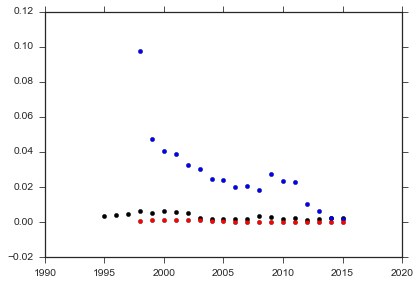

In [216]:
r_portfolio={}
plt.figure()
for y in stock_res.keys():
    r_portfolio[y]=(stock_res[y].loc[:,sample_stock].fillna(0)).dot(sample_weights)
    plt.scatter(y,r_portfolio[y].std(),c='black')
    if y>1997:
        plt.scatter(y,vol_spear.loc[y],c='blue')
        plt.scatter(y,vol_pears.loc[y],c='red')
    

In [219]:
mean_corr_spear.loc[sample_stock,sample_stock].apply(lambda x: x*float(Vol.loc[x.name]),1)

,IMGN,HIFS,ARRS,GCI,HRG,ATO,BFS,GPC,GPK,CDNS,...,CYN,GK,IIIN,CBU,EDE,CLF,ESV,IGT,HRTX,HRS
IMGN,0.089658,-0.008894,0.003027,-0.008350,-0.008714,-0.012510,-0.006519,-0.022173,-0.009342,-0.017104,...,-0.017546,0.001608,0.001230,-0.014164,-0.013635,-0.005090,-0.013102,-0.014718,0.013437,-0.017164
HIFS,-0.005219,0.052613,0.001691,-0.002104,0.005043,0.009709,0.005294,0.005350,0.001091,0.004309,...,0.002780,0.001047,-0.007004,0.001239,0.009396,-0.002809,-0.001534,0.008361,-0.001728,0.006346
ARRS,0.001792,0.001705,0.053064,0.004367,0.000099,-0.003732,-0.005687,-0.000805,0.001072,0.001279,...,-0.000894,-0.003404,-0.000910,-0.002765,-0.006230,-0.002228,-0.003189,-0.000421,0.002693,0.005358
GCI,-0.004742,-0.002036,0.004191,0.050919,-0.000383,0.002321,-0.001903,0.004854,0.002158,0.002839,...,0.002080,-0.001430,0.001823,-0.004349,-0.004798,-0.000361,0.003693,0.005744,-0.005271,0.002746
HRG,-0.006311,0.006223,0.000121,-0.000488,0.064928,0.005726,0.002036,0.004171,0.000796,-0.002415,...,0.005511,-0.001522,0.001120,0.001857,0.005247,-0.007217,-0.006631,0.005987,-0.000853,0.006082
ATO,-0.004481,0.005926,-0.002259,0.001464,0.002832,0.032114,0.011994,0.009939,0.004838,0.001944,...,0.000123,0.000045,-0.001108,0.000222,0.021539,-0.002613,0.005344,0.003378,-0.000778,0.004854
BFS,-0.002509,0.003472,-0.003699,-0.001289,0.001082,0.012888,0.034507,0.005441,0.003445,0.000836,...,-0.002512,0.001275,0.000289,0.002163,0.016037,-0.001853,0.001344,-0.000868,0.001635,0.000655
GPC,-0.006838,0.002812,-0.000419,0.002636,0.001776,0.008557,0.004360,0.027651,0.004711,0.002822,...,0.004886,-0.001998,-0.000886,0.000422,0.008015,0.000113,0.001381,0.003837,-0.004255,0.007678
GPK,-0.004247,0.000845,0.000824,0.001728,0.000500,0.006141,0.004070,0.006944,0.040763,0.003255,...,0.000509,0.002206,-0.002536,-0.002873,0.005733,0.000645,0.001347,0.000752,-0.001730,0.003589
CDNS,-0.007652,0.003285,0.000966,0.002236,-0.001492,0.002428,0.000971,0.004094,0.003203,0.040111,...,0.001656,0.001944,-0.004174,-0.000773,0.003769,-0.001507,0.002169,0.003097,-0.005634,0.010535


In [211]:
mean_corr_pearson.loc[sample_stock][sample_stock]

,IMGN,HIFS,ARRS,GCI,HRG,ATO,BFS,GPC,GPK,CDNS,...,CYN,GK,IIIN,CBU,EDE,CLF,ESV,IGT,HRTX,HRS
IMGN,1.000000,-0.013432,-0.003580,-0.025322,0.073696,0.038954,-0.031637,0.023214,-0.044476,0.022753,...,0.045825,0.078609,0.003700,0.000717,-0.054236,0.113635,-0.019600,0.124257,-0.010405,0.029566
HIFS,-0.013432,1.000000,-0.015600,0.050779,-0.051836,0.034713,-0.001328,0.024244,0.010137,-0.066112,...,-0.023990,-0.059107,0.001554,0.017343,-0.001624,-0.014376,-0.032899,-0.012966,-0.007859,0.017878
ARRS,-0.003580,-0.015600,1.000000,0.098296,0.003453,0.022191,0.100581,0.072212,-0.037969,0.031151,...,-0.066686,0.053998,0.059425,-0.006764,0.050454,-0.028068,0.004070,0.064696,-0.030534,0.036843
GCI,-0.025322,0.050779,0.098296,1.000000,-0.007650,0.081234,-0.013914,0.166185,-0.013594,0.057873,...,0.043406,0.043062,0.014279,0.067148,0.004523,0.137650,0.130063,0.089464,0.063781,0.146260
HRG,0.073696,-0.051836,0.003453,-0.007650,1.000000,0.038498,0.039851,0.003938,0.078055,0.007598,...,0.038588,0.020572,0.030430,0.021453,0.051712,0.011371,-0.005433,0.079796,-0.009344,-0.052849
ATO,0.038954,0.034713,0.022191,0.081234,0.038498,1.000000,0.030328,0.103183,0.047655,0.004888,...,0.054959,0.002505,0.048410,0.043907,0.031675,0.060311,0.002946,0.048489,0.078773,0.039295
BFS,-0.031637,-0.001328,0.100581,-0.013914,0.039851,0.030328,1.000000,-0.003126,0.037926,0.009681,...,-0.004622,-0.025474,0.034073,0.026323,0.034101,0.009707,-0.032017,0.059313,0.045952,0.024460
GPC,0.023214,0.024244,0.072212,0.166185,0.003938,0.103183,-0.003126,1.000000,-0.078393,0.023087,...,0.034469,0.006008,0.037718,0.000526,0.051959,0.078345,0.050959,-0.030567,-0.009770,0.051384
GPK,-0.044476,0.010137,-0.037969,-0.013594,0.078055,0.047655,0.037926,-0.078393,1.000000,-0.011080,...,0.018370,-0.057620,0.037088,0.059662,-0.029677,0.048816,-0.063181,-0.035505,0.046476,0.079793
CDNS,0.022753,-0.066112,0.031151,0.057873,0.007598,0.004888,0.009681,0.023087,-0.011080,1.000000,...,0.018125,0.137881,-0.015622,0.010153,0.078427,0.143076,0.016847,-0.044774,-0.007933,0.108196


In [387]:
Corr={}
for y in range(1995,2016):
    print(y)
    NN=nodes[y].loc[nodes[y].Id.apply(lambda x: False if x[:4]=='lev_' else True)]
    lev=nodes[y].loc[nodes[y].Id.apply(lambda x: False if x[:4]!='lev_' else True)]
    lev=lev.sort_values(by='Id',ascending=False)
    Corr[y]=pd.DataFrame(np.zeros(corr_pearson[y].shape),index=corr_pearson[y].index, columns=corr_pearson[y].columns)
    heads={l:[] for l in lev.Id}
    for i in range(lev.shape[0]):
        print(i,lev.shape[0])
        neighbor_adj=A[y].loc[A[y].loc[lev.iloc[i].Id]>0,A[y].loc[lev.iloc[i].Id]>0]
        index=list(np.where((neighbor_adj>=float(lev.iloc[i].Id[4:8])).sum()>0)[0])
        clus=np.intersect1d(list(neighbor_adj.iloc[index].index.values),NN)
        Corr[y].loc[clus,clus]=float(lev.iloc[i].Id[4:8])
        lower_clus=[]
        heads[lev.iloc[i].Id]=list(clus)
        for l in np.intersect1d(list(neighbor_adj.iloc[index].index.values),lev.Id):
            heads[lev.iloc[i].Id]+=heads[l]
            lower_clus+=heads[l]
        heads[lev.iloc[i].Id]=list(set(heads[lev.iloc[i].Id]))
        lower_clus=list(set(lower_clus))
        #print(heads[lev.iloc[i].Id])
        Corr[y].loc[clus,lower_clus]=pd.DataFrame([A[y].loc[lev.iloc[i].Id,lower_clus].values]*len(clus),index=list(clus),columns=lower_clus)
        Corr[y].loc[lower_clus,clus]=Corr[y].loc[clus,lower_clus].T
        index2=list(np.where((neighbor_adj<float(lev.iloc[i].Id[4:8])).sum()>0)[0])
        upper_clus=np.intersect1d(list(neighbor_adj.iloc[index2].index.values),NN)
        Corr[y].loc[heads[lev.iloc[i].Id],upper_clus]=pd.DataFrame([A[y].loc[lev.iloc[i].Id,upper_clus].values]*len(clus),index=clus,columns=upper_clus)
        Corr[y].loc[upper_clus,heads[lev.iloc[i].Id]]=Corr[y].loc[heads[lev.iloc[i].Id],upper_clus].T

1995
(0, 200)
(1, 200)
(2, 200)
(3, 200)
(4, 200)
(5, 200)
(6, 200)
(7, 200)
(8, 200)
(9, 200)
(10, 200)
(11, 200)
(12, 200)
(13, 200)
(14, 200)
(15, 200)
(16, 200)
(17, 200)
(18, 200)
(19, 200)
(20, 200)
(21, 200)
(22, 200)
(23, 200)
(24, 200)
(25, 200)
(26, 200)
(27, 200)
(28, 200)
(29, 200)
(30, 200)
(31, 200)
(32, 200)
(33, 200)
(34, 200)
(35, 200)
(36, 200)
(37, 200)
(38, 200)
(39, 200)
(40, 200)
(41, 200)
(42, 200)
(43, 200)
(44, 200)
(45, 200)
(46, 200)
(47, 200)
(48, 200)
(49, 200)
(50, 200)
(51, 200)
(52, 200)
(53, 200)
(54, 200)
(55, 200)
(56, 200)
(57, 200)
(58, 200)
(59, 200)
(60, 200)
(61, 200)
(62, 200)
(63, 200)
(64, 200)
(65, 200)
(66, 200)
(67, 200)
(68, 200)
(69, 200)
(70, 200)
(71, 200)
(72, 200)
(73, 200)
(74, 200)
(75, 200)
(76, 200)
(77, 200)
(78, 200)
(79, 200)
(80, 200)
(81, 200)
(82, 200)
(83, 200)
(84, 200)
(85, 200)
(86, 200)
(87, 200)
(88, 200)
(89, 200)
(90, 200)
(91, 200)
(92, 200)
(93, 200)
(94, 200)
(95, 200)
(96, 200)
(97, 200)
(98, 200)
(99, 200)
(100,

In [390]:
for y in range(1995,2016):
    Corr[y].to_csv('/Users/cdonnat/Dropbox/data/tent_Corr_'+str(y)+'.csv')

In [396]:
Corr[y]=Corr[y].fillna(0)
np.fill_diagonal(Corr[y].values,1)

In [397]:
Corr[y]

,AGO,AGN,AGM,ERII,ERIE,KRG,BWA,BWC,ENDP,GT,...,YRCW,YUM,ZAZA,ZBRA,ZEUS,ZIGO,ZION,ZIXI,ZLC,ZQK
AGO,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGN,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.52754,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGM,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERII,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERIE,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KRG,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BWA,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BWC,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENDP,0.0,0.457898,0.000000,0.0,0.000000,0.0,0.0,0.0,1.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GT,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [401]:
y=1995
NN=nodes[y].loc[nodes[y].Id.apply(lambda x: False if x[:4]=='lev_' else True)]

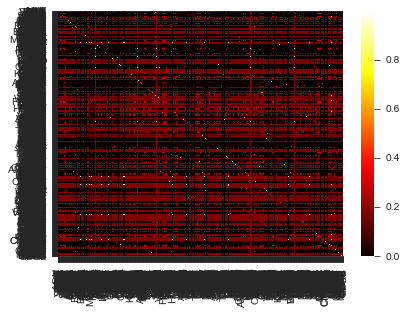

In [407]:
import seaborn as sb
sb.heatmap(Corr[1995].loc[NN.Id,NN.Id],cmap='hot',annot=False)

ERROR! Session/line number was not unique in database. History logging moved to new session 302


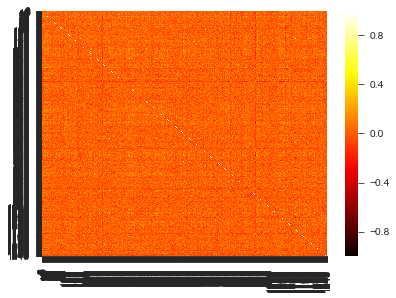

In [406]:
sb.heatmap(corr_spear[1995].loc[NN.Id,NN.Id].values,cmap='hot',annot=False)

In [237]:

for i in range(lev.shape[0]):
    neighbor_adj=A[y].loc[A[y].loc[lev.iloc[i].Id]>0,A[y].loc[lev.iloc[i].Id]>0]
    index=list(np.where((neighbor_adj>=float(lev.iloc[i].Id[4:8])).sum()>0)[0])
    clus=list(neighbor_adj.iloc[index].index.values)
    Corr.loc[clus,clus]=float(lev.iloc[i].Id[4:8])
    index2=list(np.where((neighbor_adj<float(lev.iloc[i].Id[4:8])).sum()>0)[0])
    upper_clus=np.intersect1d(list(neighbor_adj.iloc[index2].index.values),NN)
    Corr.loc[clus,upper_clus]=pd.DataFrame([A[y].loc[lev.iloc[i].Id,upper_clus]]*len(clus),index=clus)
    Corr.loc[upper_clus,clus]=Corr.loc[clus,upper_clus].T
    

In [248]:
y=1995
edges[y].loc[edges[y].Source==lev.iloc[0].Id]

ValueError: Can only compare identically-labeled Series objects

In [281]:
A[y].loc[lev.iloc[0].Id,A[y].loc[lev.iloc[0].Id]>=float(lev.iloc[0].Id[4:8])]>float(lev.iloc[0].Id[4:8])

XCRA    True
LTXC    True
Name: lev_0.94_5, dtype: bool

In [285]:
np.where((A[y].loc[A[y].loc[lev.iloc[0].Id]>0,A[y].loc[lev.iloc[0].Id]>0]>float(lev.iloc[0].Id[4:8])).sum()>0)

(array([260, 434]),)

In [288]:
A[y].loc[A[y].loc[lev.iloc[0].Id]>0,A[y].loc[lev.iloc[0].Id]>0].iloc[[260, 434]].index.values

array(['XCRA', 'LTXC'], dtype=object)

In [291]:
clus=list(A[y].loc[A[y].loc[lev.iloc[0].Id]>0,A[y].loc[lev.iloc[0].Id]>0].iloc[[260, 434]].index.values)

In [293]:
index=np.where((A[y].loc[A[y].loc[lev.iloc[0].Id]>0,A[y].loc[lev.iloc[0].Id]>0]>float(lev.iloc[0].Id[4:8])).sum()>0)[0]
   

In [295]:
index=list(np.where((A[y].loc[A[y].loc[lev.iloc[0].Id]>0,A[y].loc[lev.iloc[0].Id]>0]>float(lev.iloc[0].Id[4:8])).sum()>0)[0])
clus=list(A[y].loc[A[y].loc[lev.iloc[0].Id]>0,A[y].loc[lev.iloc[0].Id]>0].iloc[index].index.values)

In [322]:
neighbor_adj=A[y].loc[A[y].loc[lev.iloc[i].Id]>0,A[y].loc[lev.iloc[i].Id]>0]
index=list(np.where((neighbor_adj>=float(lev.iloc[i].Id[4:8])).sum()>0)[0])
clus=list(neighbor_adj.iloc[index].index.values)
Corr.loc[clus,clus]=float(lev.iloc[i].Id[4:8])
index2=list(np.where((neighbor_adj<float(lev.iloc[i].Id[4:8])).sum()>0)[0])
upper_clus=np.intersect1d(list(neighbor_adj.iloc[index2].index.values),NN)
Corr.loc[clus,upper_clus]=pd.DataFrame([A[1995].loc[lev.iloc[i].Id,upper_clus]]*len(clus),index=clus)
Corr.loc[upper_clus,clus]=Corr.loc[clus,upper_clus].T

In [323]:
upper_clus

array(['AAN', 'AAON', 'AAPL', 'ABM', 'ABMD', 'ACET', 'ACFN', 'ACO', 'ADBE',
       'ADM', 'ADSK', 'ADTN', 'AE', 'AEC', 'AEGN', 'AEPI', 'AFAM', 'AGCO',
       'AGII', 'AGYS', 'AIN', 'AIR', 'AIV', 'AJG', 'AKR', 'ALOG', 'AMAG',
       'AMD', 'AME', 'AMGN', 'AMWD', 'ANIK', 'ANN', 'AOS', 'APAGF', 'APOL',
       'ARIA', 'AROW', 'ARRS', 'ASBC', 'ASEI', 'ASNA', 'ASTE', 'ATK',
       'ATMI', 'ATNI', 'ATO', 'ATRI', 'ATRO', 'ATW', 'AVNR', 'AXAS', 'AXE',
       'AZO', 'AZPN', 'BANF', 'BBBY', 'BBOX', 'BBSI', 'BCPC', 'BDC', 'BDN',
       'BEAM', 'BFS', 'BGG', 'BH', 'BHE', 'BIIB', 'BIO', 'BIOL', 'BLX',
       'BOKF', 'BONT', 'BPFH', 'BPOP', 'BRK_A', 'BRO', 'BTX', 'BXS', 'BZH',
       'CACI', 'CAKE', 'CAMP', 'CAS', 'CBB', 'CBL', 'CBM', 'CBR', 'CBRL',
       'CBT', 'CBU', 'CDI', 'CECE', 'CELG', 'CERN', 'CFI', 'CFNB', 'CFR',
       'CHCO', 'CHD', 'CHDN', 'CHDX', 'CHE', 'CHS', 'CINF', 'CKH', 'CKP',
       'CLDX', 'CLH', 'CLI', 'CMI', 'CMN', 'CMTL', 'CNBKA', 'COLB', 'COO',
       'CPF', 'CQB', 'CR', 'CRD_

In [325]:
Corr.loc[upper_clus,clus]

,XCRA,LTXC
AAN,0.179487,0.179487
AAON,0.179487,0.179487
AAPL,0.179487,0.179487
ABM,0.179487,0.179487
ABMD,0.179487,0.179487
ACET,0.179487,0.179487
ACFN,0.179487,0.179487
ACO,0.179487,0.179487
ADBE,0.179487,0.179487
ADM,0.179487,0.179487
